# Costco Stock Data Analysis


## Introduction and Project Objectives 

This analysis report presents  of Costco (COST) historical stock data from March 2020 to March 2025. The analysis contain two main analytical approaches: clustering analysis to identify distinct market regimes and time series forecasting to predict future price movements. 

Key findings include the identification of two main stock regimes characterized by different levels, significant seasonal patterns in price movements, and superior forecasting performance of SARIMA models compared to standard ARIMA models. These insights provide valuable information for investors and financial analysts interested in Costco stock behavior and potential investment strategies.

In [1]:
# Data manipulation libraries
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import math

# Visualization libraries
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go 
from plotly.subplots import make_subplots

# Clustering libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Time series analysis libraries
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Suppress warnings
import warnings
warnings.filterwarnings('ignore') 

## Data Understanding

This dataset includes five years of Costco (COST) stock price data (March 2020–March 2025) with 1,256 entries. It tracks daily trading details: Date (object), Open, High, Low, Close (all float), and Volume (integer). File size is 59 KB.

In [2]:
# Load Costso Dataset
df  = pd.read_csv('COSTCO_historical_data.csv', skiprows=[1, 2])

In [3]:
df.head()

Price       Close        High         Low        Open   Volume
0  2020-03-19  280.787628  288.726815  278.404957  285.562179  5429500
1  2020-03-20  267.172333  283.354277  264.044475  283.271484  6581200
2  2020-03-23  262.673828  272.002153  256.132985  268.635126  5646400
3  2020-03-24  262.131073  273.547678  260.189960  271.008602  7124200
4  2020-03-25  258.377563  267.448300  256.859649  261.459407  5639600

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1256 non-null   object 
 1   Close   1256 non-null   float64
 2   High    1256 non-null   float64
 3   Low     1256 non-null   float64
 4   Open    1256 non-null   float64
 5   Volume  1256 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 59.0+ KB


## Data Preprocessing 

The dataset required several preprocessing steps to prepare for analysis:

- Fixed headers: Removed the first two rows (contained header info).
- Formatted dates: Converted the date column to datetime and set as index.
- Corrected data types: Ensured all columns had proper numeric types.
- Handled missing values: Used forward/backward filling to address gaps.

In [5]:
df = df.iloc[2:].reset_index(drop=True)  # Remove metadata rows
df.rename(columns={'Price': 'Date'}, inplace=True)  # Rename Date column
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Convert to datetime
# Ensure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df.head()

Date       Close        High         Low        Open   Volume
0 2020-03-23  262.673828  272.002153  256.132985  268.635126  5646400
1 2020-03-24  262.131073  273.547678  260.189960  271.008602  7124200
2 2020-03-25  258.377563  267.448300  256.859649  261.459407  5639600
3 2020-03-26  268.901764  270.217316  258.377518  258.819105  5463100
4 2020-03-27  261.569794  269.996553  260.649842  264.145675  4250400

In [7]:
# Display basic statistics
df.describe()

Date        Close         High          Low  \
count                           1254  1254.000000  1254.000000  1254.000000   
mean   2022-09-16 16:11:28.995215360   536.338063   540.876793   531.207495   
min              2020-03-23 00:00:00   258.377563   265.681992   256.132985   
25%              2021-06-18 18:00:00   369.671204   370.410488   366.363325   
50%              2022-09-15 12:00:00   488.875992   493.541363   483.888596   
75%              2023-12-13 18:00:00   620.668091   623.804451   612.540683   
max              2025-03-18 00:00:00  1076.859985  1078.229980  1068.010010   
std                              NaN   200.286706   201.845132   198.444015   

              Open        Volume  
count  1254.000000  1.254000e+03  
mean    536.074305  2.215595e+06  
min     258.819105  6.458000e+05  
25%     368.242583  1.600725e+06  
50%     488.796699  1.937400e+06  
75%     620.833140  2.463475e+06  
max    1076.479980  9.511600e+06  
std     200.280482  9.998129e+05

## Exploratory Data Analysis (EDA)

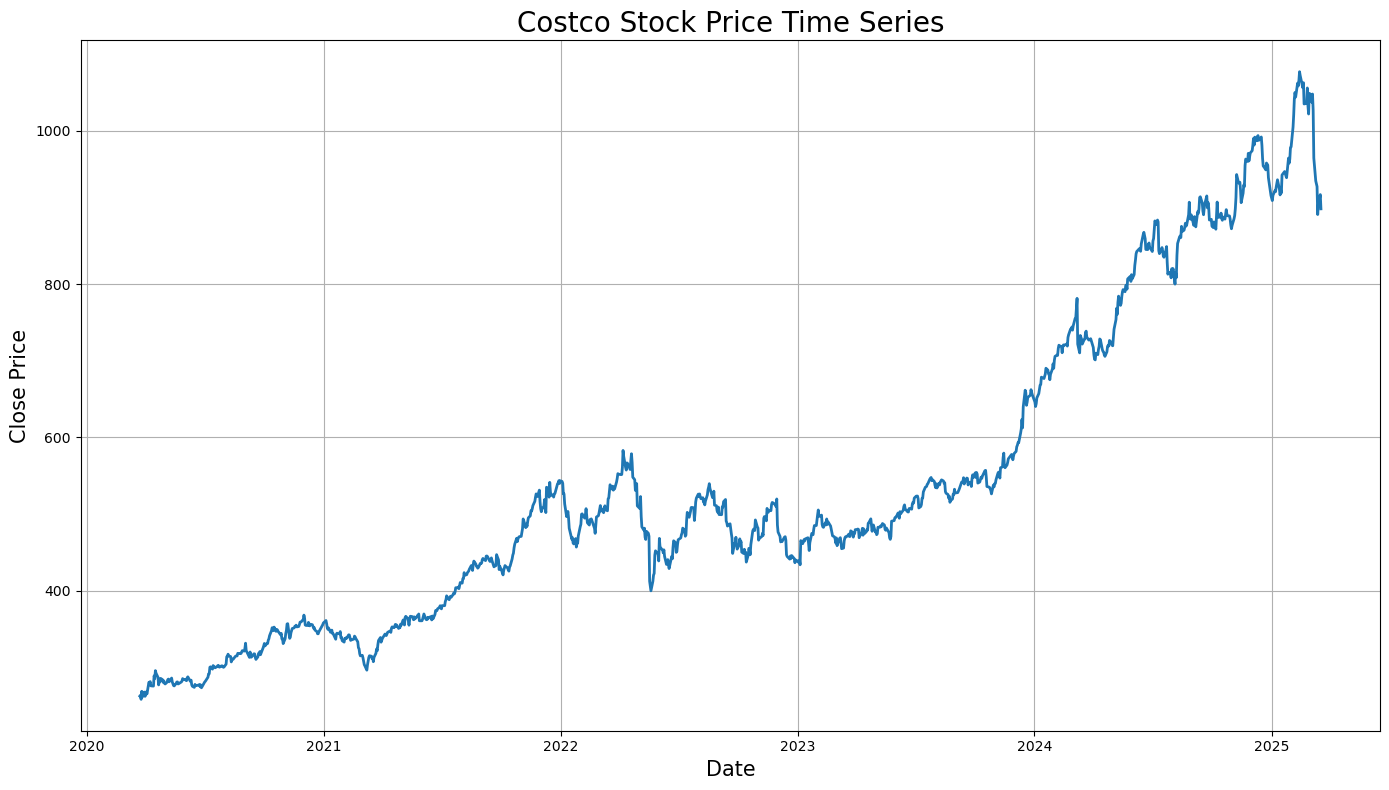

In [8]:
# Time Series Plot of Stock Prices
# Plot time series of stock prices
plt.figure(figsize=(14, 8))
plt.plot(df["Date"], df["Close"], linewidth=2)
plt.title('Costco Stock Price Time Series', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()

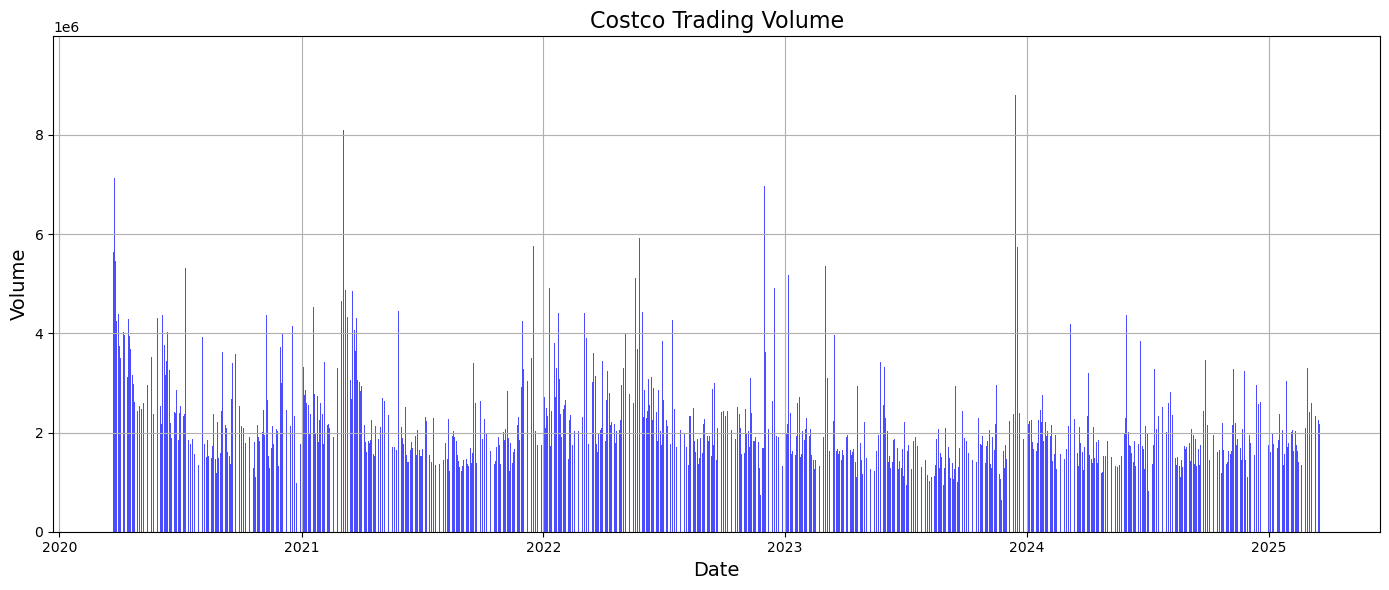

In [9]:
# Plot trading volume
plt.figure(figsize=(14, 6))
plt.bar(df["Date"], df['Volume'], alpha=0.7, color="blue")
plt.title('Costco Trading Volume', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

## Moving Averange 

In [10]:
# https://www.geeksforgeeks.org/how-to-calculate-moving-average-in-a-pandas-dataframe/
# Calculate moving averages
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

# Drop the rows with NaN values from the calculated features
df_clean = df.dropna()

print("Original shape:", df.shape)
print("Cleaned shape:", df_clean.shape)
df_clean.head()

Original shape: (1254, 9)
Cleaned shape: (1205, 9)


Date       Close        High         Low        Open   Volume  \
49 2020-06-02  283.153351  284.932907  280.968089  283.946331  2528900   
50 2020-06-03  282.738464  284.176865  282.074585  283.531417  2165900   
51 2020-06-04  286.528015  290.769465  284.997404  286.620226  4553900   
52 2020-06-05  287.717468  289.183529  283.337716  288.722503  4375600   
53 2020-06-08  283.245514  287.025938  282.572405  286.445040  3764500   

           MA5        MA20        MA50  
49  283.885468  281.453546  278.548912  
50  284.001654  281.394540  278.950204  
51  284.221094  281.480286  279.438143  
52  284.879425  281.804848  280.024941  
53  284.676562  281.862473  280.311816

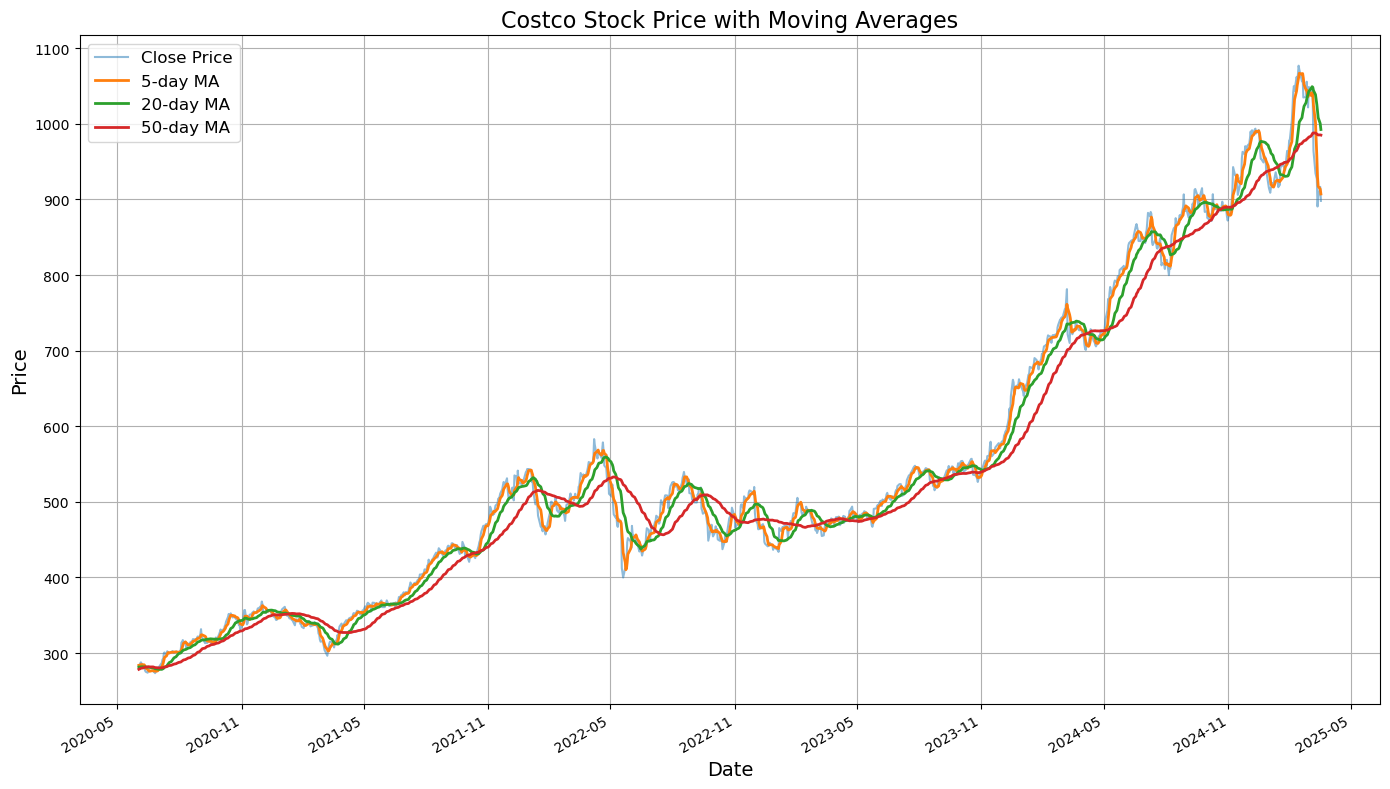

In [11]:
# Plot moving averages with proper date display
plt.figure(figsize=(14, 8))


# Plot the closing price and moving averages
plt.plot(df_clean['Date'], df_clean['Close'], label='Close Price', alpha=0.5)
plt.plot(df_clean['Date'], df_clean['MA5'], label='5-day MA', linewidth=2)
plt.plot(df_clean['Date'], df_clean['MA20'], label='20-day MA', linewidth=2)
plt.plot(df_clean['Date'], df_clean['MA50'], label='50-day MA', linewidth=2)

# Improve the x-axis date formatting
plt.gcf().autofmt_xdate()  # Auto-format the date labels
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=6))  # Show dates every 6 months

# Add title, labels, and visualize
plt.title('Costco Stock Price with Moving Averages', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# Candlestick Chart (using Plotly)
# https://plotly.com/python/candlestick-charts/
# https://www.quantstart.com/articles/k-means-clustering-of-daily-ohlc-bar-data/ 

# Select the last 100 days of data for the candlestick chart
last_100_days = df_clean.iloc[-100:].copy()

# Create the candlestick chart with proper date display
fig = go.Figure(data=[go.Candlestick(
    x=last_100_days['Date'],  # Use actual dates instead of indices
    open=last_100_days['Open'],
    high=last_100_days['High'],
    low=last_100_days['Low'],
    close=last_100_days['Close'],
    name='Candlestick'
)])

# Update layout with proper date formatting
fig.update_layout(
    title='Costco Stock Price Candlestick Chart (100 Days)',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,
    width=1000,
    height=600,
    xaxis=dict(
        type='date',  # Specify that x-axis contains date values
        tickformat='%Y-%m-%d',  # Format for displaying dates
    )
)

fig.show()

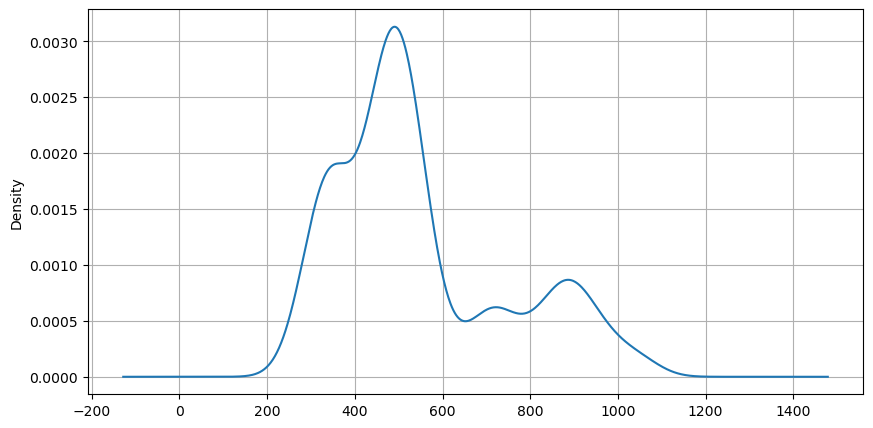

In [13]:
plt.figure(figsize=(10, 5))
df_clean["Close"].plot(kind='kde')
plt.grid(True)

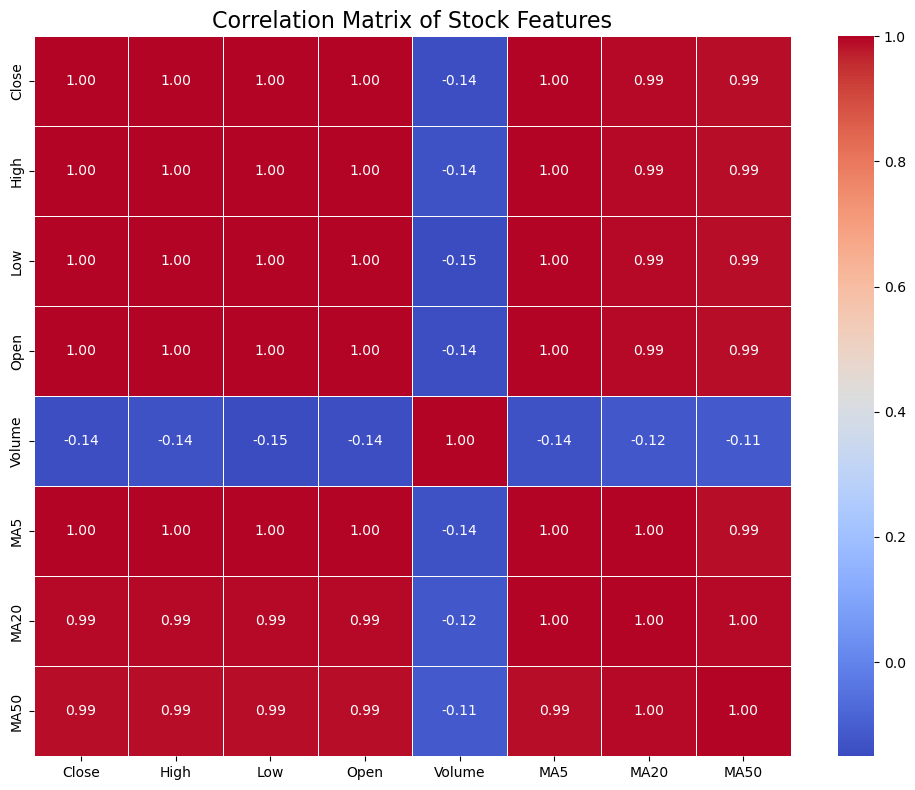

In [14]:

# Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df_clean[['Close', 'High', 'Low', 'Open', 'Volume',"MA5","MA20","MA50"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix of Stock Features', fontsize=16)
plt.tight_layout()
plt.show()


## Find Optimal K by Using Elbow Method

In [15]:
# Clustering Analysis
# Feature Selection and Scaling
# Select features for clustering
clustering_features = df_clean[['Close', 'High', 'Low', 'Open', 'Volume']].copy()

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Create a DataFrame with scaled features for easier reference
scaled_df = pd.DataFrame(scaled_features, 
                         index=clustering_features.index, 
                         columns=clustering_features.columns)


In [16]:
df_clean.head()

Date       Close        High         Low        Open   Volume  \
49 2020-06-02  283.153351  284.932907  280.968089  283.946331  2528900   
50 2020-06-03  282.738464  284.176865  282.074585  283.531417  2165900   
51 2020-06-04  286.528015  290.769465  284.997404  286.620226  4553900   
52 2020-06-05  287.717468  289.183529  283.337716  288.722503  4375600   
53 2020-06-08  283.245514  287.025938  282.572405  286.445040  3764500   

           MA5        MA20        MA50  
49  283.885468  281.453546  278.548912  
50  284.001654  281.394540  278.950204  
51  284.221094  281.480286  279.438143  
52  284.879425  281.804848  280.024941  
53  284.676562  281.862473  280.311816

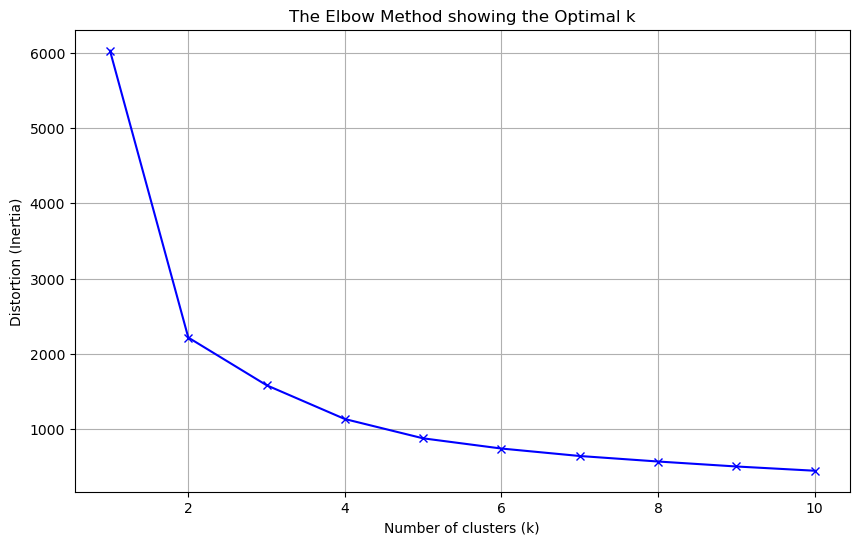

In [17]:
# Method 1 : Disdortions 
# https://www.analyticsvidhya.com/blog/2020/12/a-detailed-introduction-to-k-means-clustering-in-python/

distortions = []
K = range(1, 11)

# n_initial, default = 10, Number of time the k-means algorithm will be run with different centroid seeds. 
# The final results will be the best output of n_init consecutive runs in terms of inertia.
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_df)
    distortions.append(kmeans.inertia_)
    
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.title('The Elbow Method showing the Optimal k')
plt.grid(True)
plt.show()

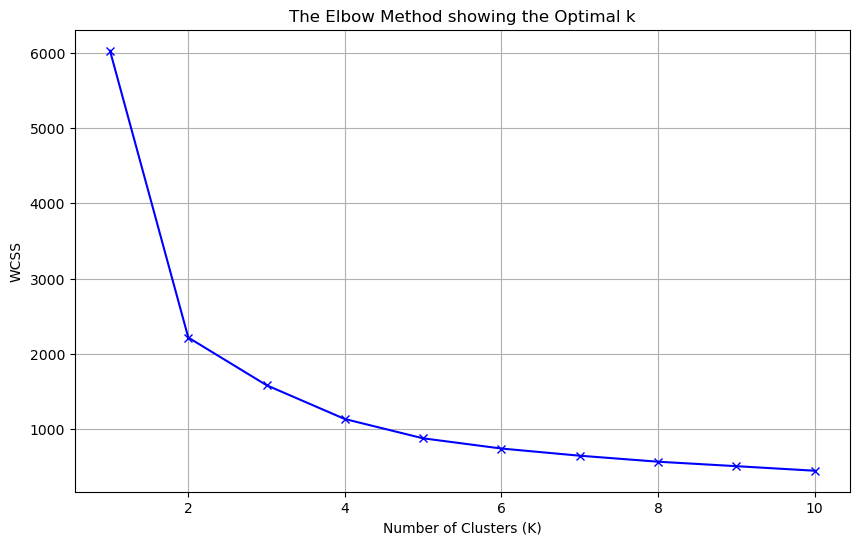

In [18]:
# Method 2 : WCSS 
#https://www.analyticsvidhya.com/blog/2021/04/k-means-clustering-simplified-in-python/

# Apply KMeans to the cleaned dataset
kmeans = KMeans(n_clusters=k, max_iter=300, n_init=10, random_state=38)


# n_initial, default = 10, Number of time the k-means algorithm will be run with different centroid seeds. 
# The final results will be the best output of n_init consecutive runs in terms of inertia.
# Elbow Method to find the optimal number of clusters
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, max_iter=300, n_init=10, random_state=38)
    kmeans.fit(scaled_df)  # Fit the model
    wcss.append(kmeans.inertia_)  # Store WCSS

# Plot the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss,'bx-')
plt.title('The Elbow Method showing the Optimal k')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

Based on the Distortion and WCSS methods for determining the optimal number of clusters, the graphs clearly show a sharp drop from 6000 to 2000 when moving from K=1 to K=2. This significant decrease indicates that dividing the data into at least two clusters is meaningful and provides substantial improvement in model fit.

From K=3 to K=5, the curve continues to decrease, but the rate of improvement becomes more gradual. This suggests that while adding more clusters continues to improve the fit, the gains are diminishing.

After K=6, the curve flattens out, meaning that adding more clusters doesn't improve the model much and may not be necessary This implies that adding more clusters beyond this point adds little additional value, and may lead to overfitting or unnecessary complexity.

## Silhouette Scores and Davies Bouldin Scores 

In [65]:
# Silhouette analysis for optimal k
silhouette_scores = []
davies_bouldin_scores = []

for k in range(2, 11):  # Silhouette Score requires at least 2 - 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    # Calculate Davies-Bouldin index
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    davies_bouldin_scores.append(db_index)
    
    print(f"For n_clusters = {k}:")
    print(f"  Silhouette Score: {silhouette_avg:.3f}")
    print(f"  Davies-Bouldin Index: {db_index:.3f}")


For n_clusters = 2:
  Silhouette Score: 0.617
  Davies-Bouldin Index: 0.564
For n_clusters = 3:
  Silhouette Score: 0.525
  Davies-Bouldin Index: 0.788
For n_clusters = 4:
  Silhouette Score: 0.488
  Davies-Bouldin Index: 0.670
For n_clusters = 5:
  Silhouette Score: 0.474
  Davies-Bouldin Index: 0.746
For n_clusters = 6:
  Silhouette Score: 0.444
  Davies-Bouldin Index: 0.793
For n_clusters = 7:
  Silhouette Score: 0.455
  Davies-Bouldin Index: 0.779
For n_clusters = 8:
  Silhouette Score: 0.447
  Davies-Bouldin Index: 0.832
For n_clusters = 9:
  Silhouette Score: 0.454
  Davies-Bouldin Index: 0.760
For n_clusters = 10:
  Silhouette Score: 0.403
  Davies-Bouldin Index: 0.800


In [20]:
# Find the k with the highest silhouette score
best_silhouette_k = range(2, 11)[silhouette_scores.index(max(silhouette_scores))]
# Find the k with the lowest Davies-Bouldin index
best_db_k = range(2, 11)[davies_bouldin_scores.index(min(davies_bouldin_scores))]

print(f"Best k according to Silhouette Score: {best_silhouette_k}")
print(f"Best k according to Davies-Bouldin Index: {best_db_k}")


Best k according to Silhouette Score: 2
Best k according to Davies-Bouldin Index: 2


In [21]:
# Choose the optimal k based on the analysis
if best_silhouette_k == best_db_k:
    optimal_k = best_silhouette_k
    print(f"Both metrics agree on optimal k = {optimal_k}")
else:
    # For this example, we'll prioritize silhouette score
    optimal_k = best_silhouette_k
    print(f"Metrics disagree. Choosing k = {optimal_k} based on Silhouette Score")

# Apply K-Means with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(scaled_features)


Both metrics agree on optimal k = 2


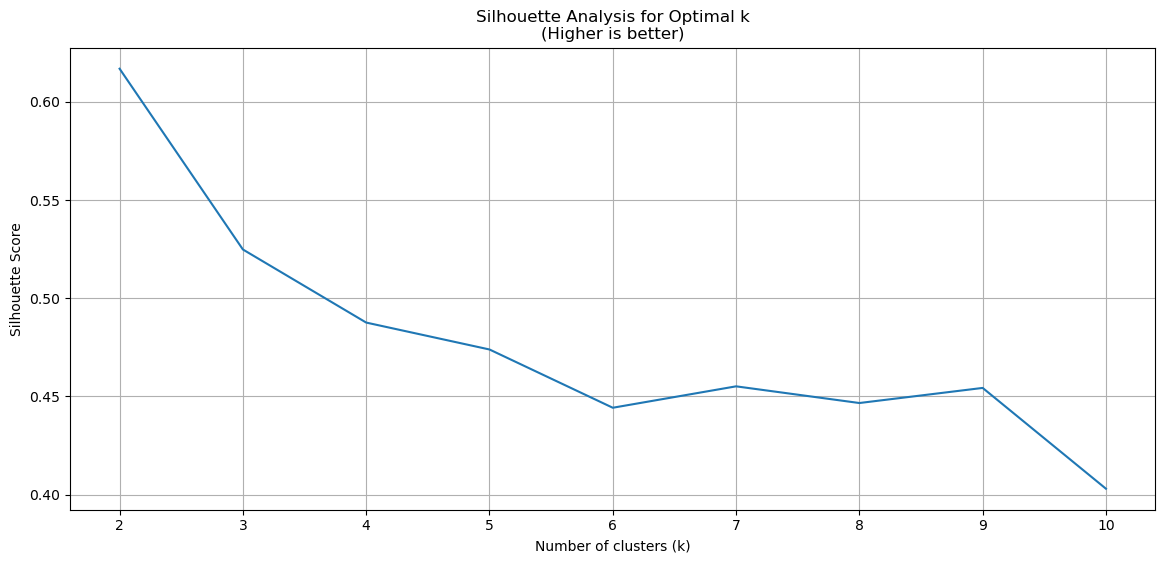

In [22]:
# Plot silhouette scores and Davies-Bouldin index
plt.figure(figsize=(14, 6))

# Plot silhouette scores

plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k\n(Higher is better)')
plt.grid(True)

plt.show()

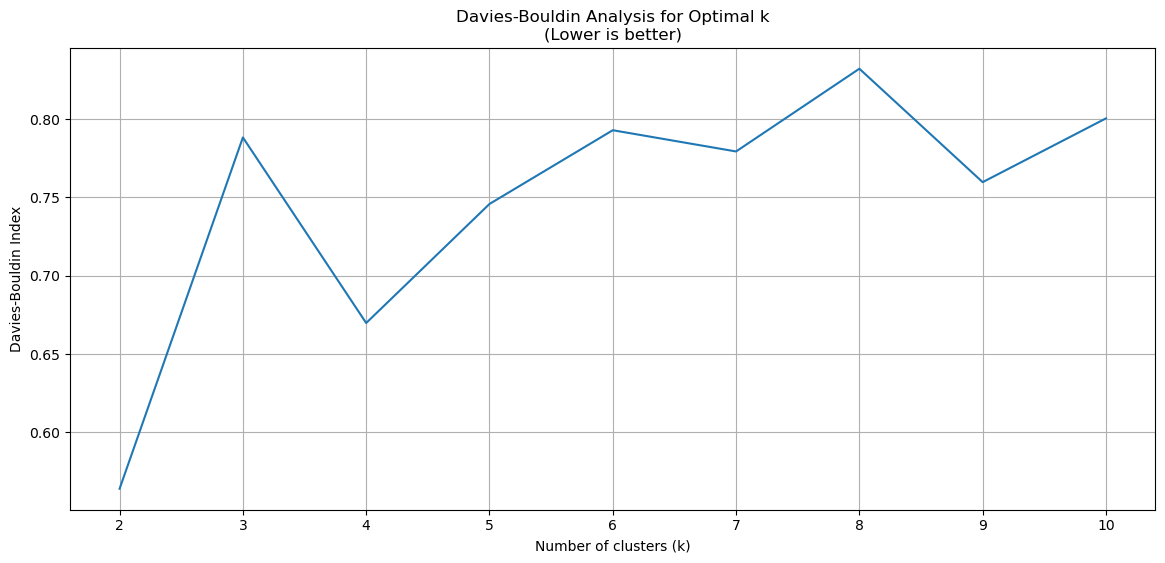

In [23]:
# Plot Davies-Bouldin index
plt.figure(figsize=(14, 6))

plt.plot(range(2, 11), davies_bouldin_scores)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Analysis for Optimal k\n(Lower is better)')
plt.grid(True)
plt.show()

Based on the evaluation shows, Silhouette Score = 0.617 is the highest score, indicating that clusters are well-separated and compact.Davies-Bouldin Index = 0.564, this is also the lowest value, showing minimal overlap between clusters. 

Conclusion, based on the Silhouette Score and Davies-Bouldin Index, K = 2 is the optimal number of clusters. 


## Silhouette Analysis for KMeans Clustering (In Detailed Explaination)

For n_clusters = 2, the average silhouette_score is: 0.617
For n_clusters = 3, the average silhouette_score is: 0.528
For n_clusters = 4, the average silhouette_score is: 0.466
For n_clusters = 5, the average silhouette_score is: 0.456
For n_clusters = 6, the average silhouette_score is: 0.473
For n_clusters = 7, the average silhouette_score is: 0.449
For n_clusters = 8, the average silhouette_score is: 0.397
For n_clusters = 9, the average silhouette_score is: 0.405
For n_clusters = 10, the average silhouette_score is: 0.400


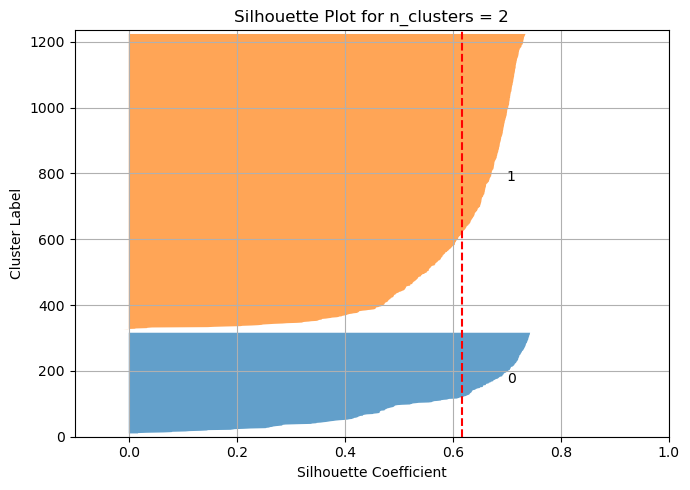

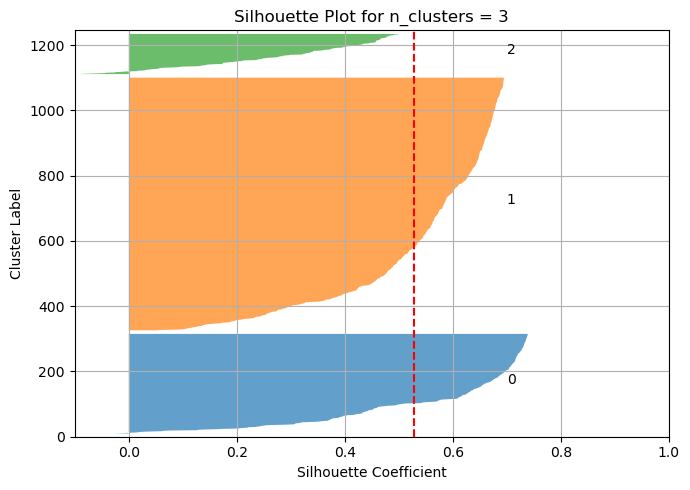

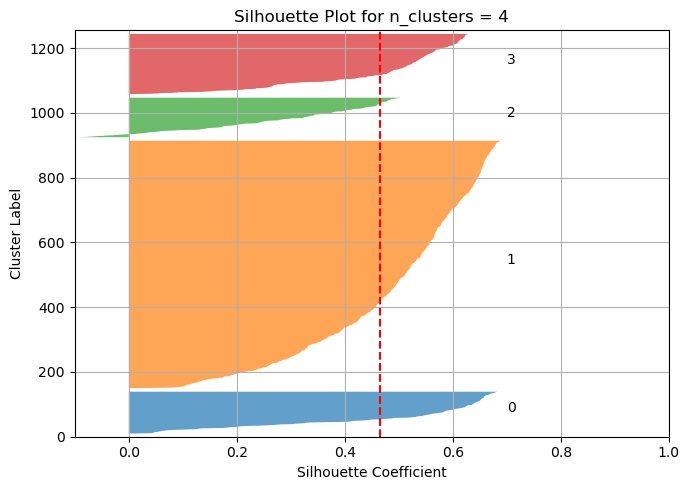

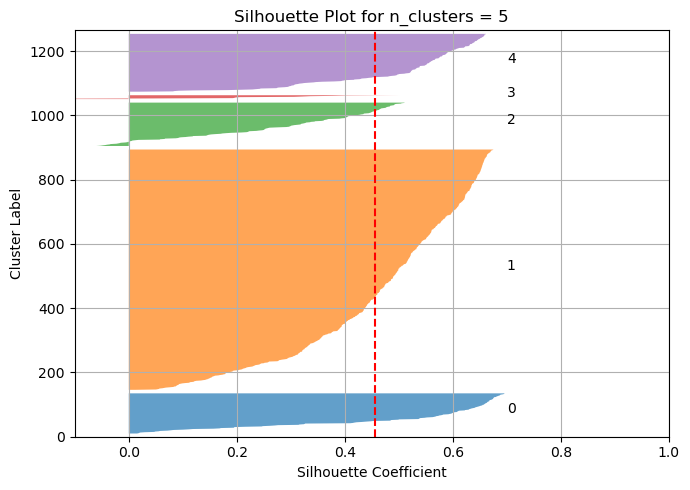

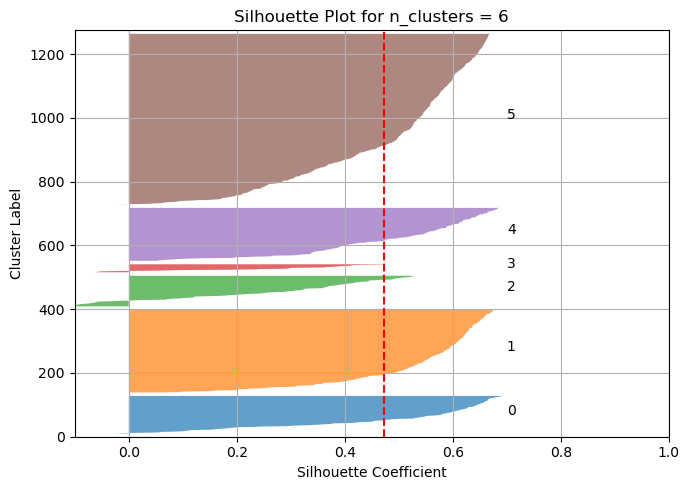

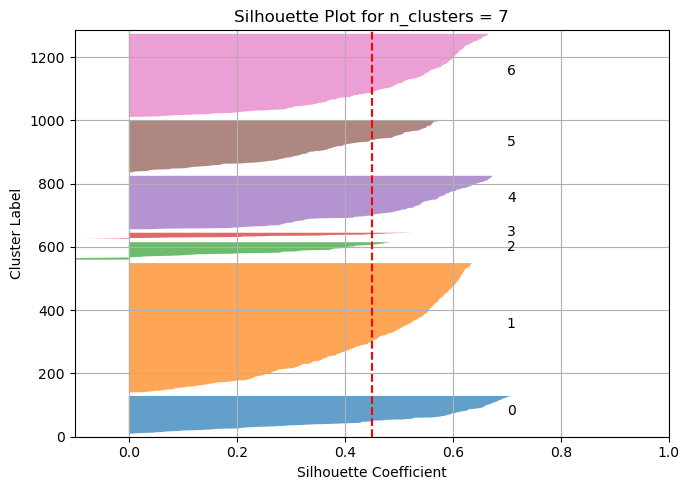

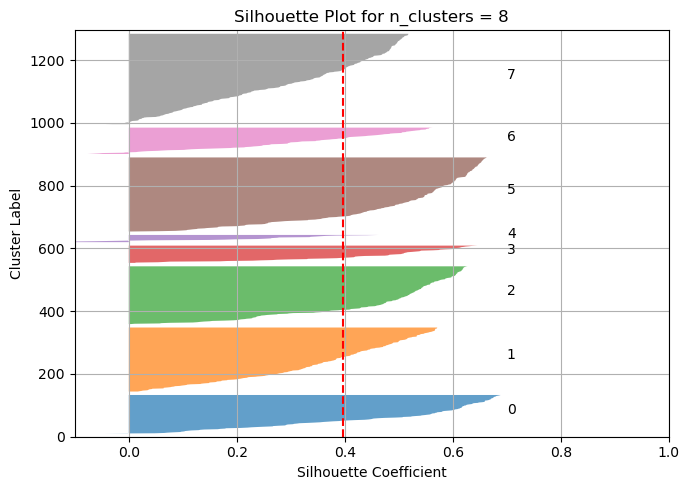

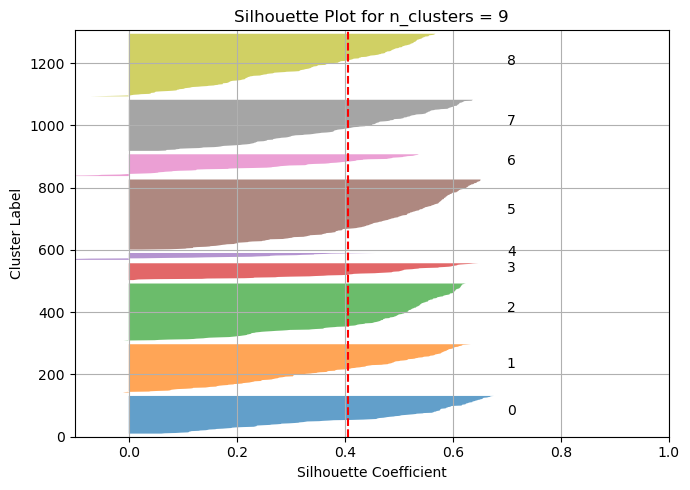

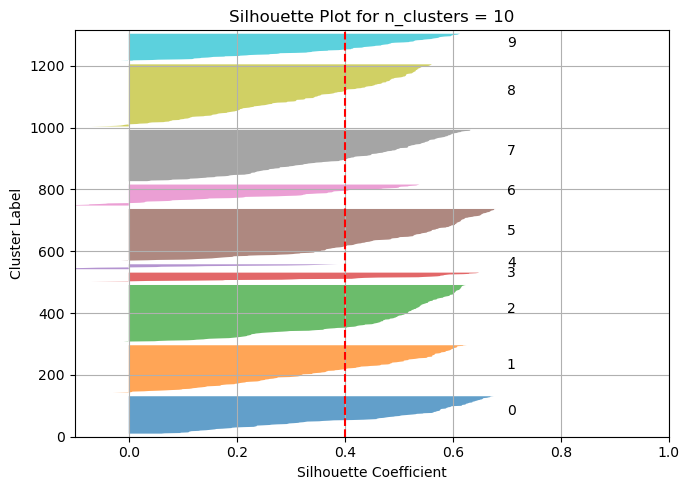

In [24]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# Loop over the number of clusters
for n_clusters in range(2, 11):
    # Initialize KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = kmeans.fit_predict(scaled_features)

    # Compute the silhouette score
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is: {silhouette_avg:.3f}")

    # Compute silhouette samples
    sample_silhouette_values = silhouette_samples(scaled_features, cluster_labels)

    # Plot silhouette
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(scaled_features) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.7)
        ax.text(0.7, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_title(f"Silhouette Plot for n_clusters = {n_clusters}")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster Label")
    plt.grid(True)
    plt.tight_layout()
plt.show()


The silhouette analysis indicates that 2-4 clusters provide the most meaningful grouping of the data.

- 2 Clusters: Works well, most of points fit nicely into clusters (silhouette score > 0.5). A few points don’t fit perfectly, but overall, it’s overall a good grouping.
- 3 Clusters: This setup remains robust, but one cluster is slightly weaker (lower score). The other two clusters are strong.
- 4 Clusters: The score drops a little, but two middle clusters are well-separated. One cluster is weaker, but it’s still acceptable.
- Beyond 4 Clusters (5 to 10): The scores keep getting worse, some clusters become too small and unclear and many points don’t fit well (low or negative silhouette scores).This means the model is overfitting, splitting the data too much without real meaning.

Conclusion, 2 clusters is the most reliable choice. If need more detail of segmentation, 3 or 4 may can be fit in the grouping, provided the additional clusters are meaningful and supported by domain knowledge.



## KMeans Clustering

In [25]:
# https://scikit-learn.org/1.4/modules/generated/sklearn.cluster.KMeans.html
# Initialise k_means by calling an object KMeans()
# Train the model using fit() method
k_means = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
k_means.fit(df_clean[["Close", "Volume","MA5","MA20","MA50"]]) # Maximum Detect 5 feature, hence i decide to choose 

KMeans(n_clusters=2, n_init=10, random_state=42)

In [26]:
# Create an additional column in the dataframe (df) as KMeans_labels
# Assign the cluster labels to the dataframe
df_clean['KMeans_labels'] = k_means.labels_


# Display the dataframe records
df_clean.head()

Date       Close        High         Low        Open   Volume  \
49 2020-06-02  283.153351  284.932907  280.968089  283.946331  2528900   
50 2020-06-03  282.738464  284.176865  282.074585  283.531417  2165900   
51 2020-06-04  286.528015  290.769465  284.997404  286.620226  4553900   
52 2020-06-05  287.717468  289.183529  283.337716  288.722503  4375600   
53 2020-06-08  283.245514  287.025938  282.572405  286.445040  3764500   

           MA5        MA20        MA50  KMeans_labels  
49  283.885468  281.453546  278.548912              1  
50  284.001654  281.394540  278.950204              1  
51  284.221094  281.480286  279.438143              0  
52  284.879425  281.804848  280.024941              0  
53  284.676562  281.862473  280.311816              0

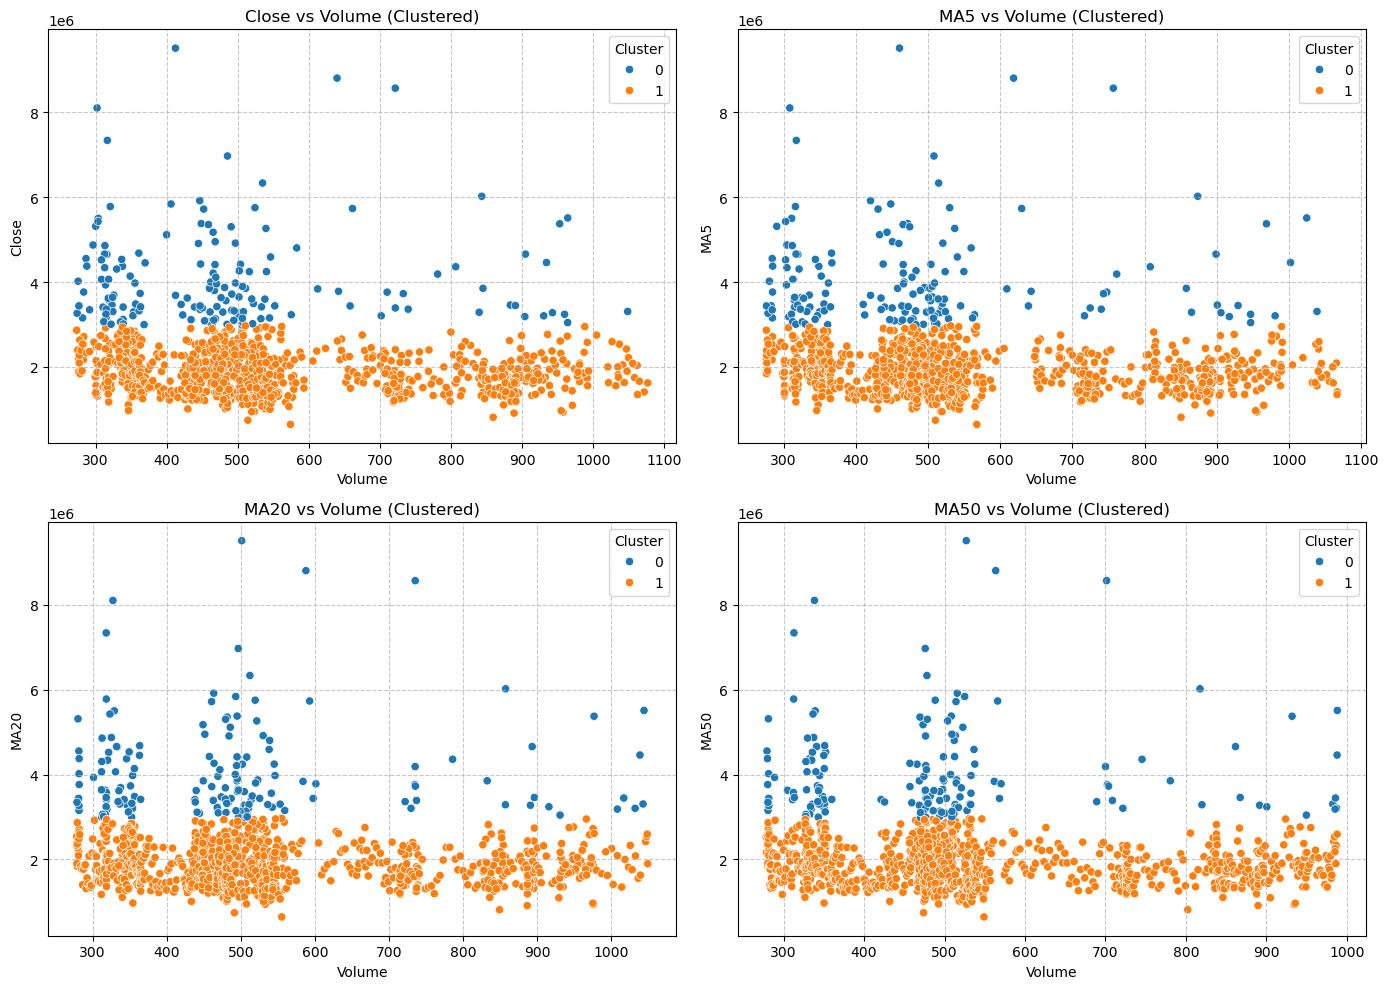

In [27]:
# Define features to plot against Volume
features_to_plot = ["Close", "MA5", "MA20", "MA50"]

# Set up the plot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.grid(True, linestyle='--', alpha=0.7)
axes = axes.flatten()


# Plot each feature vs Volume, colored by KMeans cluster
for i, feature in enumerate(features_to_plot):
    sns.scatterplot(
        x=feature,
        y='Volume',
        hue='KMeans_labels',
        data=df_clean,
        palette='tab10',
        ax=axes[i],
        legend='full'
    )
    axes[i].set_title(f'{feature} vs Volume (Clustered)')
    axes[i].set_xlabel('Volume')
    axes[i].set_ylabel(feature)
    axes[i].grid(True, linestyle='--', alpha=0.7)
    axes[i].get_legend().set_title("Cluster")

# Adjust layout and show plot
plt.tight_layout()
plt.show()

## Agglomerative Clustering

In [28]:
# https://scikit-learn.org/1.4/modules/generated/sklearn.cluster.AgglomerativeClustering.html
# Create an object model
model = AgglomerativeClustering(n_clusters=optimal_k, metric = 'euclidean')
agg_labels = model.fit_predict(scaled_features)

# Train the model by calling fit() method
model.fit(df_clean[["Close", "Volume","MA5","MA20","MA50"]])

AgglomerativeClustering()

In [29]:
# Add another column into the dataframe (df)
df_clean['HR_labels'] = model.labels_

# Display the dataframe records
df_clean.head()

Date       Close        High         Low        Open   Volume  \
49 2020-06-02  283.153351  284.932907  280.968089  283.946331  2528900   
50 2020-06-03  282.738464  284.176865  282.074585  283.531417  2165900   
51 2020-06-04  286.528015  290.769465  284.997404  286.620226  4553900   
52 2020-06-05  287.717468  289.183529  283.337716  288.722503  4375600   
53 2020-06-08  283.245514  287.025938  282.572405  286.445040  3764500   

           MA5        MA20        MA50  KMeans_labels  HR_labels  
49  283.885468  281.453546  278.548912              1          0  
50  284.001654  281.394540  278.950204              1          0  
51  284.221094  281.480286  279.438143              0          1  
52  284.879425  281.804848  280.024941              0          1  
53  284.676562  281.862473  280.311816              0          0

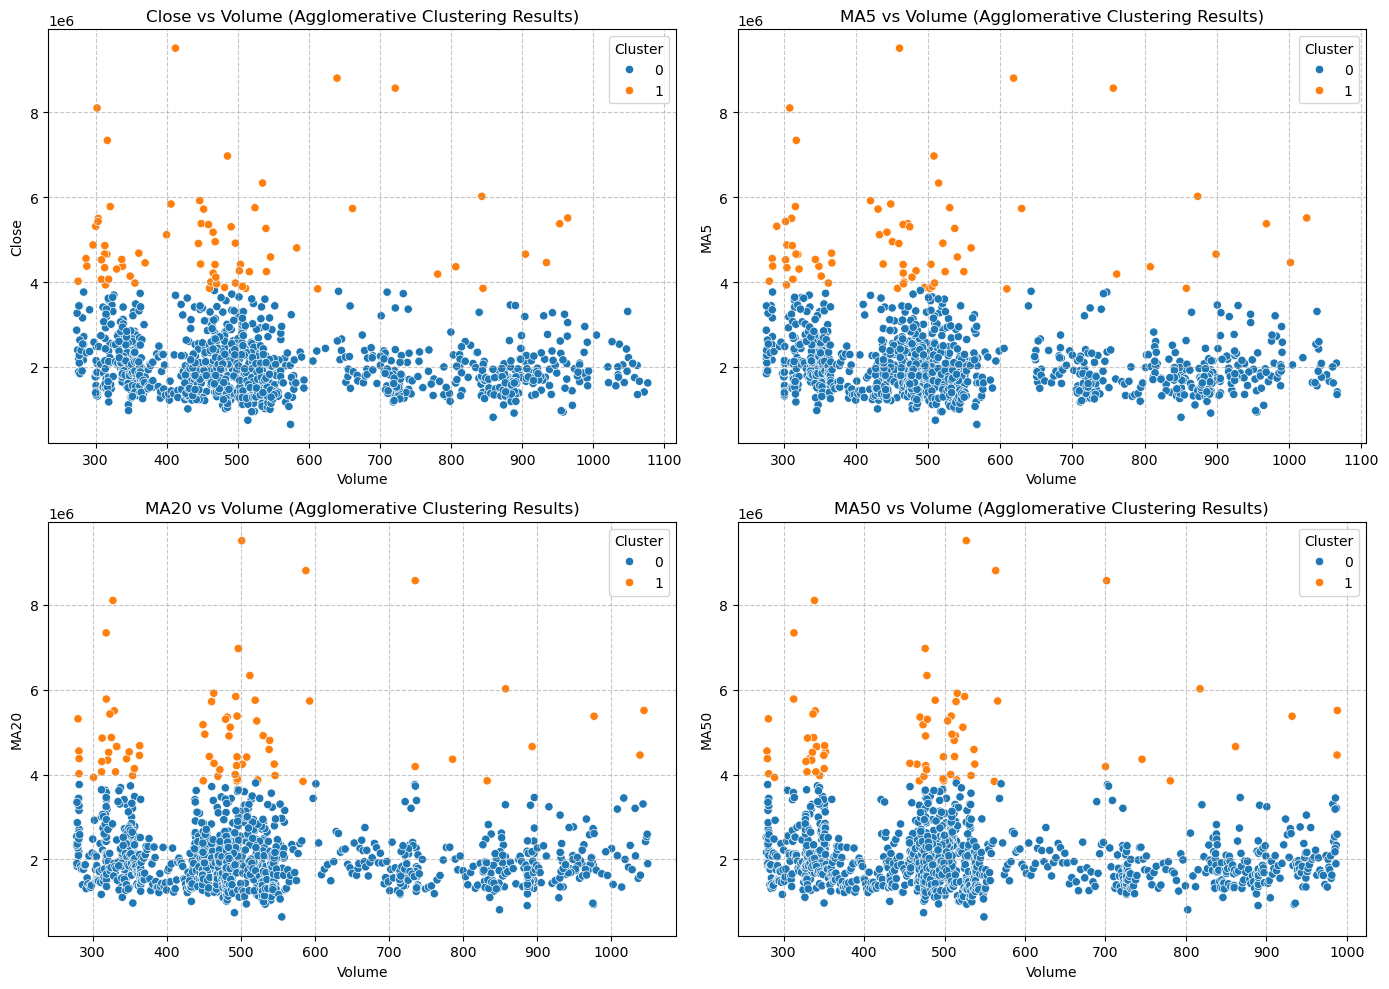

In [30]:
# Set up the plot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.grid(True, linestyle='--', alpha=0.7)
axes = axes.flatten()


# Plot each feature vs Volume, colored by KMeans cluster
for i, feature in enumerate(features_to_plot):
    sns.scatterplot(
        x=feature,
        y='Volume',
        hue='HR_labels',
        data=df_clean,
        palette='tab10',
        ax=axes[i],
        legend='full'
    )
    axes[i].set_title(f'{feature} vs Volume (Agglomerative Clustering Results)')
    axes[i].set_xlabel('Volume')
    axes[i].set_ylabel(feature)
    axes[i].grid(True, linestyle='--', alpha=0.7)
    axes[i].get_legend().set_title("Cluster")

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### Hierarchical Clustering Dendrogram

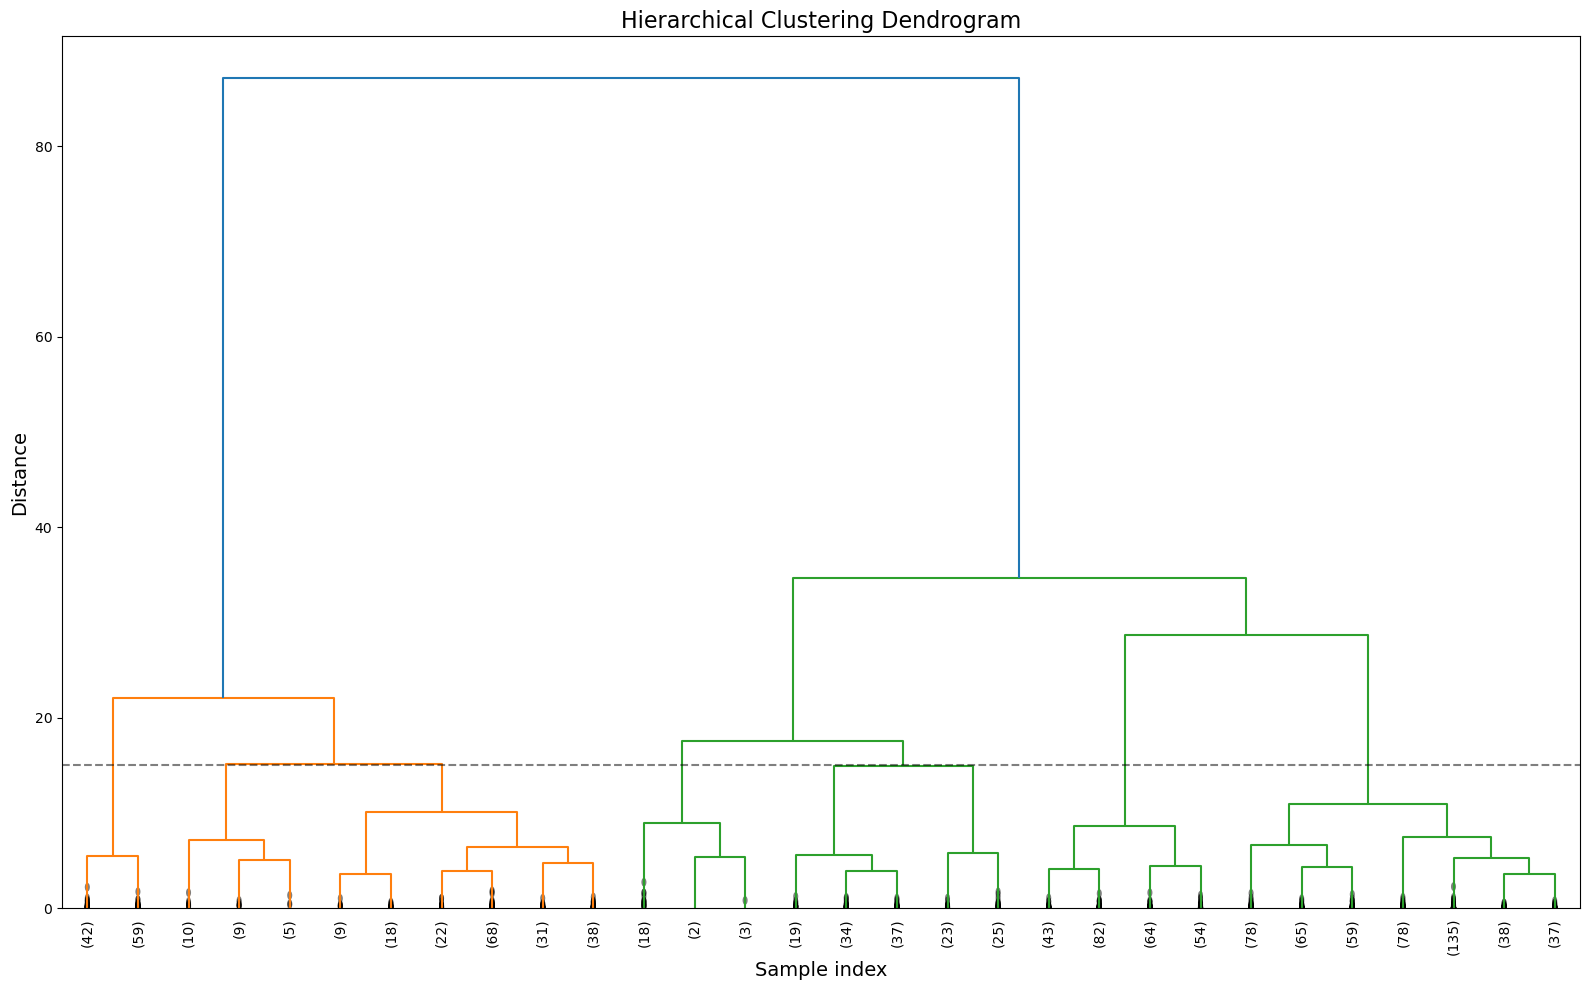

In [31]:
# Generate the linkage matrix
Z = linkage(scaled_features, method='ward')

# Plot dendrogram
plt.figure(figsize=(16, 10))
plt.title('Hierarchical Clustering Dendrogram', fontsize=16)
plt.xlabel('Sample index', fontsize=14)
plt.ylabel('Distance', fontsize=14)
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=30,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.axhline(y=15, c='k', linestyle='--', alpha=0.5)  # Draw a horizontal line to suggest a cut
plt.tight_layout()
plt.show()


## DBSCAN Clustering

In [32]:
# Create an object using dbscan
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Train the model by calling fit() method
# We take epsilon is 0.5, and min_samples or minPoints is 5. Let’s visualize the results from this model
dbscan_labels = dbscan.fit_predict(scaled_features)

In [33]:
# Add DBSCAN cluster labels to the original DataFrame
df_clean['DBSCAN_Cluster'] = dbscan_labels

# Display the dataframe records
df_clean.head()

Date       Close        High         Low        Open   Volume  \
49 2020-06-02  283.153351  284.932907  280.968089  283.946331  2528900   
50 2020-06-03  282.738464  284.176865  282.074585  283.531417  2165900   
51 2020-06-04  286.528015  290.769465  284.997404  286.620226  4553900   
52 2020-06-05  287.717468  289.183529  283.337716  288.722503  4375600   
53 2020-06-08  283.245514  287.025938  282.572405  286.445040  3764500   

           MA5        MA20        MA50  KMeans_labels  HR_labels  \
49  283.885468  281.453546  278.548912              1          0   
50  284.001654  281.394540  278.950204              1          0   
51  284.221094  281.480286  279.438143              0          1   
52  284.879425  281.804848  280.024941              0          1   
53  284.676562  281.862473  280.311816              0          0   

    DBSCAN_Cluster  
49               0  
50               0  
51               0  
52               0  
53               0

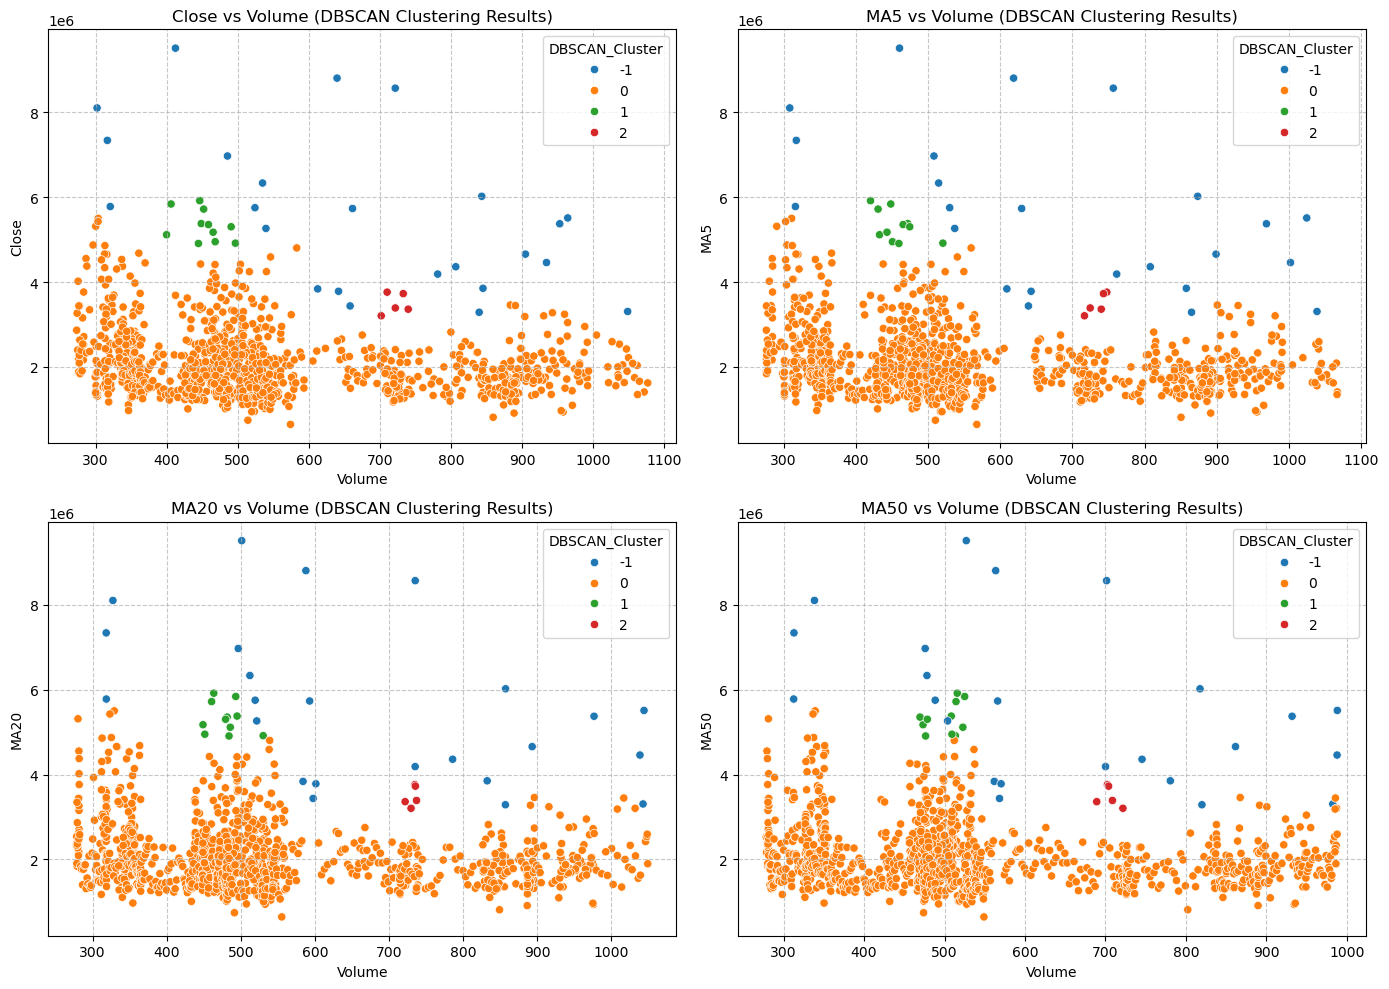

In [34]:
# Set up the plot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.grid(True, linestyle='--', alpha=0.7)
axes = axes.flatten()


# Plot each feature vs Volume, colored by KMeans cluster
for i, feature in enumerate(features_to_plot):
    sns.scatterplot(
        x=feature,
        y='Volume',
        hue='DBSCAN_Cluster',
        data=df_clean,
        palette='tab10',
        ax=axes[i],
        legend='full'
    )
    axes[i].set_title(f'{feature} vs Volume (DBSCAN Clustering Results)')
    axes[i].set_xlabel('Volume')
    axes[i].set_ylabel(feature)
    axes[i].grid(True, linestyle='--', alpha=0.7)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

#### Conclusion:
 - K-Means and Agglomerative Clustering both perform similarly in this scenario with two clusters. However, Agglomerative Clustering seems to handle the data slightly better with more complex structures.

 - DBSCAN offers a unique advantage by identifying noise points (-1), which suggests that it’s useful in cases where  expect outliers. The clustering is also flexible in terms of shape, allowing for more irregularly shaped clusters than K-Means. However, DBSCAN might not work well in cases where the data is densely clustered but not highly variable in shape.

## Clustering Performance Evaluation

In [35]:
# Evaluate K-Means clustering
kmeans_silhouette = silhouette_score(scaled_features, kmeans_labels)
kmeans_db = davies_bouldin_score(scaled_features, kmeans_labels)

print(f"K-Means Clustering Evaluation:")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Davies-Bouldin Index: {kmeans_db:.4f}")


K-Means Clustering Evaluation:
Silhouette Score: 0.6169
Davies-Bouldin Index: 0.5641


In [36]:
# Evaluate DBSCAN clustering
# Only calculate if there are at least 2 clusters and not all points are noise
if len(set(dbscan_labels)) >= 2 and -1 not in dbscan_labels:
    dbscan_silhouette = silhouette_score(scaled_features, dbscan_labels)
    dbscan_db = davies_bouldin_score(scaled_features, dbscan_labels)
    
    print(f"\nDBSCAN Clustering Evaluation:")
    print(f"Silhouette Score: {dbscan_silhouette:.4f}")
    print(f"Davies-Bouldin Index: {dbscan_db:.4f}")
elif -1 in dbscan_labels:
    # If there are noise points, calculate metrics excluding them
    mask = dbscan_labels != -1
    if len(set(dbscan_labels[mask])) >= 2 and sum(mask) > 0:
        dbscan_silhouette = silhouette_score(scaled_features[mask], dbscan_labels[mask])
        dbscan_db = davies_bouldin_score(scaled_features[mask], dbscan_labels[mask])
        
        print(f"\nDBSCAN Clustering Evaluation (excluding noise points):")
        print(f"Silhouette Score: {dbscan_silhouette:.4f}")
        print(f"Davies-Bouldin Index: {dbscan_db:.4f}")
        print(f"Number of noise points: {list(dbscan_labels).count(-1)} out of {len(dbscan_labels)}")
    else:
        print("\nDBSCAN did not form valid clusters for evaluation after excluding noise points.")
        dbscan_silhouette = float('nan')
        dbscan_db = float('nan')
else:
    print("\nDBSCAN did not form valid clusters for evaluation.")
    dbscan_silhouette = float('nan')
    dbscan_db = float('nan')



DBSCAN Clustering Evaluation (excluding noise points):
Silhouette Score: 0.1304
Davies-Bouldin Index: 0.7814
Number of noise points: 24 out of 1205


In [37]:
# Evaluate Agglomerative clustering
agg_silhouette = silhouette_score(scaled_features, agg_labels)
agg_db = davies_bouldin_score(scaled_features, agg_labels)

print(f"\nAgglomerative Clustering Evaluation:")
print(f"Silhouette Score: {agg_silhouette:.4f}")
print(f"Davies-Bouldin Index: {agg_db:.4f}")



Agglomerative Clustering Evaluation:
Silhouette Score: 0.6143
Davies-Bouldin Index: 0.5681


In [38]:
# Compare the clustering algorithms
algorithms = ['K-Means', 'Agglomerative','DBSCAN']
silhouette_scores = [kmeans_silhouette, dbscan_silhouette, agg_silhouette]
db_scores = [kmeans_db, dbscan_db, agg_db]

# Create a comparison dataframe
comparison_df_clean = pd.DataFrame({
    'Algorithm': algorithms,
    'Silhouette Score': silhouette_scores,
    'Davies-Bouldin Index': db_scores
})

# Display the comparison
print("\nClustering Algorithm Comparison:")
print(comparison_df_clean)




Clustering Algorithm Comparison:
       Algorithm  Silhouette Score  Davies-Bouldin Index
0        K-Means          0.616909              0.564073
1  Agglomerative          0.130431              0.781438
2         DBSCAN          0.614286              0.568097


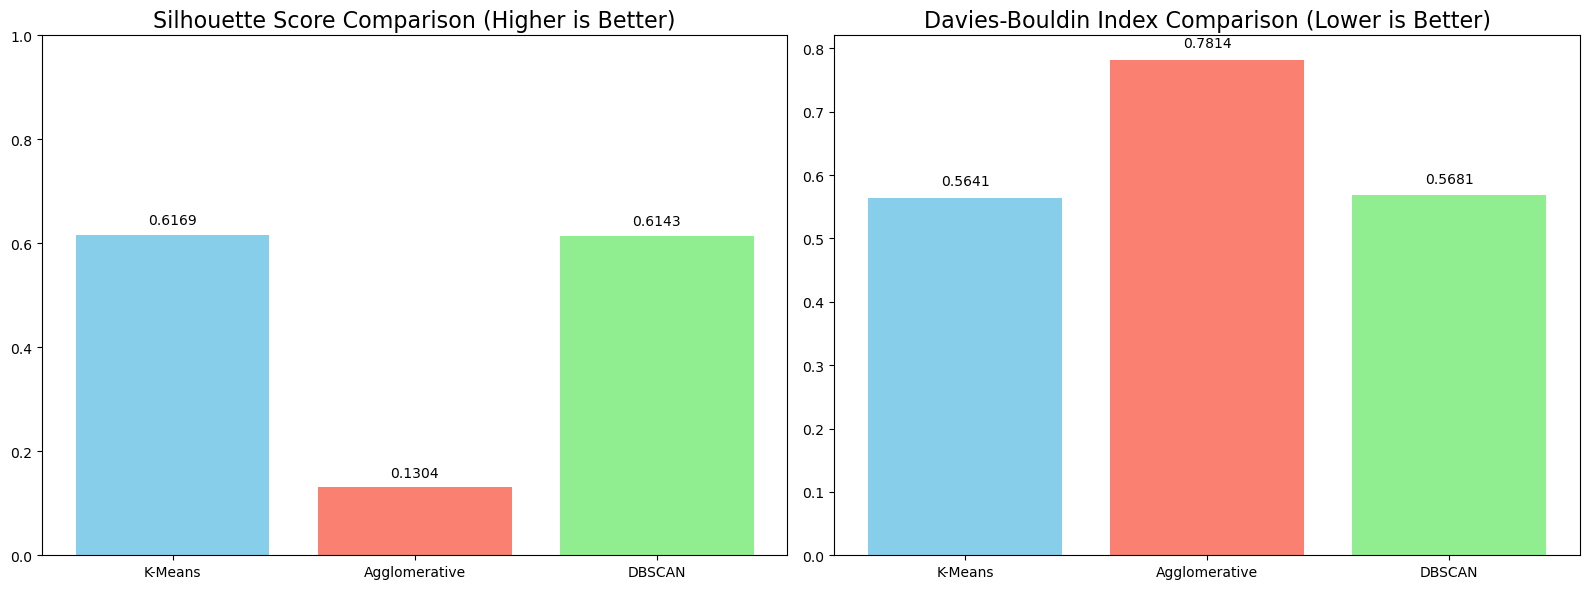

In [39]:
# Visualize the comparison
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Silhouette Score (higher is better)
ax[0].bar(algorithms, silhouette_scores, color=['skyblue', 'salmon', 'lightgreen'])
ax[0].set_title('Silhouette Score Comparison (Higher is Better)', fontsize=16)
ax[0].set_ylim(0, 1)  # Silhouette score ranges from -1 to 1
for i, v in enumerate(silhouette_scores):
    if not np.isnan(v):
        ax[0].text(i, v + 0.02, f"{v:.4f}", ha='center')
    else:
        ax[0].text(i, 0.02, "N/A", ha='center')

# Davies-Bouldin Index (lower is better)
ax[1].bar(algorithms, db_scores, color=['skyblue', 'salmon', 'lightgreen'])
ax[1].set_title('Davies-Bouldin Index Comparison (Lower is Better)', fontsize=16)
for i, v in enumerate(db_scores):
    if not np.isnan(v):
        ax[1].text(i, v + 0.02, f"{v:.4f}", ha='center')
    else:
        ax[1].text(i, 0.02, "N/A", ha='center')

plt.tight_layout()
plt.show()


Based on the clustering comparison results shown in the provided graphs shows three clustering algorithms (K-Means, DBSCAN, and Agglomerative Clustering) reveals clear performance differences. K-Means performs best, achieving the highest Silhouette Score (0.6169) and lowest Davies-Bouldin Index (0.5641), indicating well-defined, distinct clusters. Agglomerative Clustering follows closely (Silhouette: 0.6143; DB: 0.5681). DBSCAN, however, struggles with both metrics (Silhouette: 0.1304; DB: 0.7814), producing less separable clusters even after excluding noise. 

For this dataset, K-Means is the most effective choice, balancing cluster quality and separation, while DBSCAN proves unsuitable due to its poor performance.

# Time Series Analysis

### Augmented Dicky Fuller - Test for Stationarity Testing

In [70]:
# https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/
# https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/
# https://www.researchgate.net/publication/375551467_Research_on_the_Augmented_Dickey-Fuller_Test_for_Predicting_Stock_Prices_and_Returns
# Augmented Dickey-Fuller test (ADF Test)
ad_fuller_result = adfuller(df_clean['Close'])

# Display the outcome of Augmented Dicky-Fuller Test
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.13993072321659766
p-value: 0.9453131602002951


In [41]:
df_clean['Close Difference'] = df_clean['Close'] - df_clean['Close'].shift(1)
# Shift index by desired number of periods with an optional time `freq`.

# Show first five records
df_clean.head()

Date       Close        High         Low        Open   Volume  \
49 2020-06-02  283.153351  284.932907  280.968089  283.946331  2528900   
50 2020-06-03  282.738464  284.176865  282.074585  283.531417  2165900   
51 2020-06-04  286.528015  290.769465  284.997404  286.620226  4553900   
52 2020-06-05  287.717468  289.183529  283.337716  288.722503  4375600   
53 2020-06-08  283.245514  287.025938  282.572405  286.445040  3764500   

           MA5        MA20        MA50  KMeans_labels  HR_labels  \
49  283.885468  281.453546  278.548912              1          0   
50  284.001654  281.394540  278.950204              1          0   
51  284.221094  281.480286  279.438143              0          1   
52  284.879425  281.804848  280.024941              0          1   
53  284.676562  281.862473  280.311816              0          0   

    DBSCAN_Cluster  Close Difference  
49               0               NaN  
50               0         -0.414886  
51               0          3.789551  
52               0          1.189453  
53               0         -4.471954

In [42]:
# Drop NA values
df_clean.dropna(subset = ["Close Difference"], inplace = True)

# Show first five records
df_clean.head()

Date       Close        High         Low        Open   Volume  \
50 2020-06-03  282.738464  284.176865  282.074585  283.531417  2165900   
51 2020-06-04  286.528015  290.769465  284.997404  286.620226  4553900   
52 2020-06-05  287.717468  289.183529  283.337716  288.722503  4375600   
53 2020-06-08  283.245514  287.025938  282.572405  286.445040  3764500   
54 2020-06-09  281.733368  284.545647  281.383011  283.531383  3155800   

           MA5        MA20        MA50  KMeans_labels  HR_labels  \
50  284.001654  281.394540  278.950204              1          0   
51  284.221094  281.480286  279.438143              0          1   
52  284.879425  281.804848  280.024941              0          1   
53  284.676562  281.862473  280.311816              0          0   
54  284.392566  281.642104  280.715088              0          0   

    DBSCAN_Cluster  Close Difference  
50               0         -0.414886  
51               0          3.789551  
52               0          1.189453  
53               0         -4.471954  
54               0         -1.512146

In [67]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(df_clean["Close Difference"])

# Display the outcomes of Dicky Fuller test
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}') 

ADF Statistic: -7.548841993752222
p-value: 3.2290425566358144e-11



The Augmented Dickey-Fuller (ADF) test was used to check stationarity for ARIMA modeling. The original closing price series showed non-stationarity (ADF: -0.1545, p-value: 0.9437), as the high p-value indicates a unit root is present. However, after first-order differencing, the series became stationary (ADF: -7.5488, p-value: 3.22e-11((which is 0.00000000003229), way below 0.05), with the low p-value confirming no unit root. This means differencing (d=1) is necessary for ARIMA to work effectively on this data.

In Conclusion, the null hypothesis is rejected.
The time series is stationary (no unit root).
This means the statistical properties of the series remain constant over time.
Stationary data is suitable for time series modeling like ARIMA without differencing.


### Differenced Series (Cross-Check)

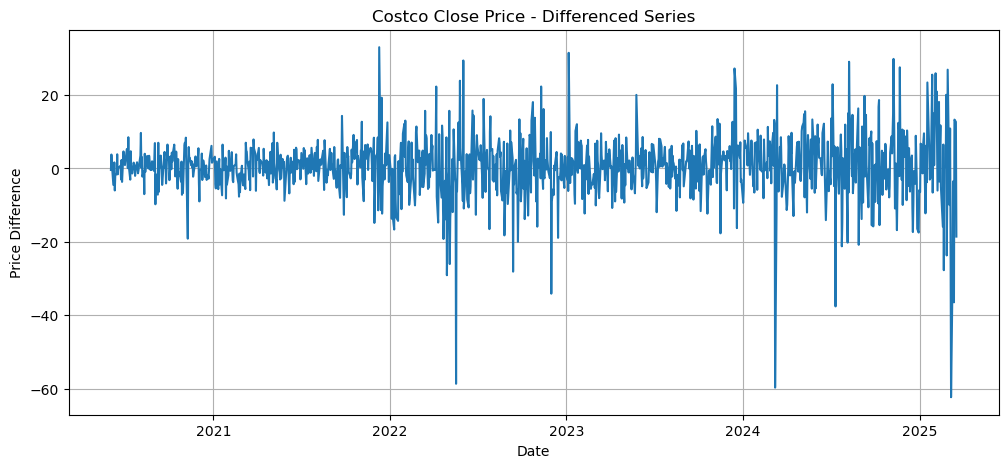

In [44]:
plt.figure(figsize = [12, 5]); # Set dimensions for figure
plt.plot(df_clean["Date"], df_clean["Close Difference"])
plt.title('Costco Close Price - Differenced Series')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.grid(True)
plt.show()



It confirmed that, no seasonal pattern, no repeating cyclical pattern. This suggests a non-seasonal ARIMA model is appropriate.

# Seasonal Decomposition - To Determine if the data is seasonal or not


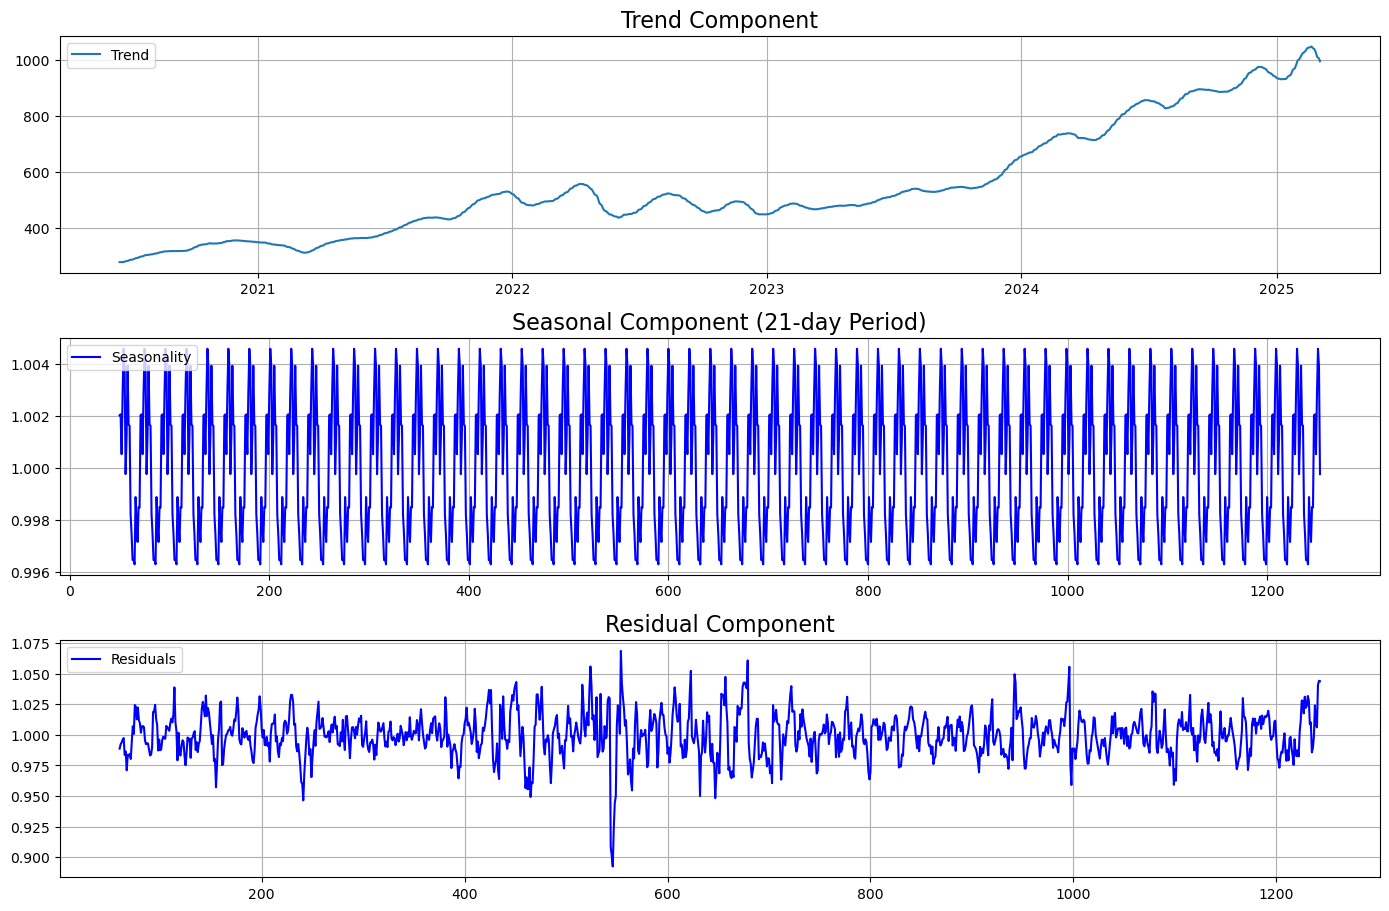

In [68]:
# Perform seasonal decomposition
# 5 for weekly (5 trading days)
# 21 for monthly (21 trading days)
# Try with monthly seasonality (21 trading days)

decomposition = sm.tsa.seasonal_decompose(df_clean['Close'], model='multiplicative', period=21)

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(14, 12))


# Trend components
plt.subplot(411)
plt.plot(df_clean['Date'], trend, label='Trend')
plt.legend(loc='upper left')
plt.grid(True)
plt.title('Trend Component',fontsize=16)

# Seasonality components
plt.subplot(412)
plt.plot(seasonal, label='Seasonality', color='blue')
plt.legend(loc='upper left')
plt.grid(True)
plt.title('Seasonal Component (21-day Period)',fontsize=16)

# Residuals components
plt.subplot(413)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='upper left')
plt.grid(True)
plt.title('Residual Component',fontsize=16)


plt.tight_layout()
plt.show()




Above Seasonal Decomposition graph shows, strong grotwh trend, Costso stock prices rose steadily from 2020-2025, with accelerated growth after mid-2022. Seasonal component visualise regular monthly patterns (21 trading-day cycles) with minimal price impact with approximately 0.4% and clean residuals, from random fluctuations confirm effective decomposition, with minor isolated spikes

The clear monthly cycles suggest SARIMA (seasonal ARIMA) would better capture these patterns than standard ARIMA for short-term forecasting. While the trend dominates overall price movement, incorporating the 21-day seasonal component could improve prediction accuracy for monthly timeframes.
 

# ACF and PACF Plots

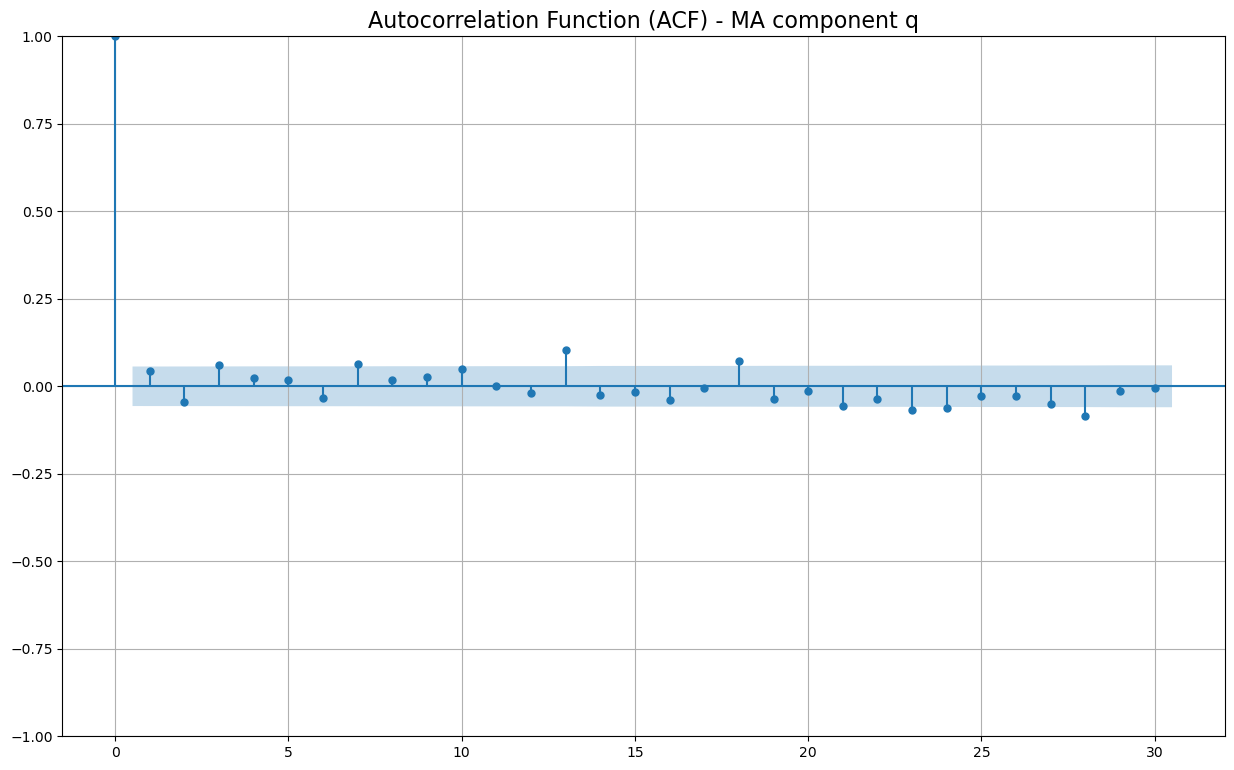

In [46]:

fig = plt.figure(figsize = (15, 20))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_clean['Close Difference'].dropna(),lags = 30,ax = ax1)
ax1.set_title('Autocorrelation Function (ACF) - MA component q', fontsize=16)
ax1.grid(True)  



The ACF plot shows autocorrelation drops sharply after lag 0 and stays near zero, confirming the series is stationary. The only notable spike occurs at lag 13, exceeding the confidence bounds. This suggests a simple MA structure q=0 or q=1 for the basic pattern, with q=13 only if modeling that specific lag. It confirms stationarity again, because no slow decay or sinusoidal wave, which would indicate seasonality or a trend.



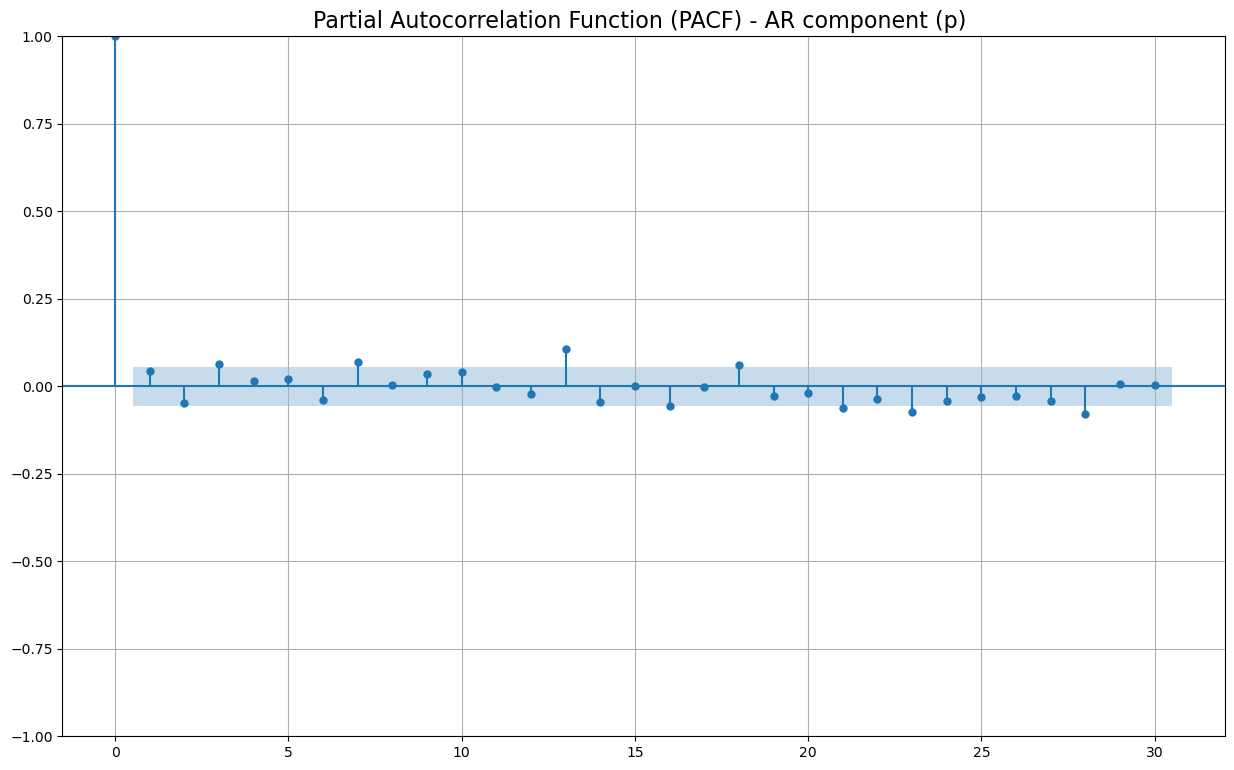

In [47]:

fig = plt.figure(figsize = (15, 20))
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_clean['Close Difference'].dropna(),lags = 30,ax = ax2)
ax2.set_title('Partial Autocorrelation Function (PACF) - AR component (p) ', fontsize=16)
ax2.grid(True) 


The PACF plot shows partial autocorrelation drops sharply after lag 0 and stays near zero, it confirming the series is stationary. The only notable spike occurs at lag 13, exceeding the confidence bounds. This suggests a simple AR structure (p=0 or p=1) for the basic pattern, with p=13 only if modeling that specific lag. It confirms stationarity again, as no persistent decay or multiple significant lags appear, which would indicate more complex dependencies. The clean cutoff after lag 0 is characteristic of an AR process, while the lag 13 spike may represent an isolated higher-order effect worth considering.


# ARIMA Modeling

In [48]:
# https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/

# Split the data into training and testing
split_index = int(len(df) * 0.8)
train = df_clean['Close'].iloc[:split_index]
test = df_clean['Close'].iloc[split_index:]


print(f"Training set size: {len(train)}")
print(f"Testing set size: {len(test)}")


Training set size: 1003
Testing set size: 201


In [49]:
# A nested loop is written to calculate the AIC values
aicVal=[]
for d in range(0,2): # d is be 0 or 1
    for ari in range(0, 2): # ari is p: p = 0 or 1
        for maj in range(0,2): # maj is q: q = 0 or 1
            try:
                arima_obj = ARIMA(df_clean['Close'].tolist(), order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass
print(aicVal)

[[0, 0, 0, 16144.654673843472], [0, 0, 1, 14533.2592752976], [1, 0, 0, 8491.403789139265], [1, 0, 1, 8490.17592373969], [0, 1, 0, 8473.36527497562], [0, 1, 1, 8472.21275016442], [1, 1, 0, 8472.510453906732], [1, 1, 1, 8463.674430028183]]


In [50]:
np.random.seed(42)
# Declare and initialise an object 'arima_obj' by calling a method 'ARIMA()'
arima_obj = ARIMA(df_clean['Close'].tolist(), order = (1, 1, 1))

# d = 1, the number of times that the raw observations are differenced, also called the degree of differencing.
# Train the ARIMA model by calling a method fit()
arima_obj_fit = arima_obj.fit()

# Display the summary of the trained model
print(arima_obj_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1204
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4228.837
Date:                Mon, 21 Apr 2025   AIC                           8463.674
Time:                        11:44:27   BIC                           8478.952
Sample:                             0   HQIC                          8469.429
                               - 1204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8208      0.061    -13.448      0.000      -0.940      -0.701
ma.L1          0.8819      0.050     17.572      0.000       0.784       0.980
sigma2        66.1915      1.236     53.566      0.0

## Evaluate ARIMA Forecast

In [51]:
# Forecast next points matching the length of the test set
forecast_steps = len(test)  # Forecast for the same length as test set
result = arima_obj_fit.get_forecast(steps=forecast_steps)
forecast = result.predicted_mean

# Evaluate model performance using test data
predictions = forecast  # Forecasted values are used as predictions

# Calculate evaluation metrics
evaluation_results = pd.DataFrame({
    'mean_absolute_error': [mean_absolute_error(test, predictions)],
    'mean_squared_error': [mean_squared_error(test, predictions)],
    'root_mean_squared_error': [np.sqrt(mean_squared_error(test, predictions))],
    'mean_absolute_percentage_error': [np.mean(np.abs((predictions - test) / np.maximum(np.abs(test), 1e-5))) * 100]
})

# Display the results
print("\nEvaluation Metrics:")
print(f" - MSE : {evaluation_results['mean_squared_error'].values[0]:.4f}")
print(f" - RMSE: {evaluation_results['root_mean_squared_error'].values[0]:.4f}")
print(f" - MAE : {evaluation_results['mean_absolute_error'].values[0]:.4f}")
print(f" - MAPE: {evaluation_results['mean_absolute_percentage_error'].values[0]:.4f}%")


Evaluation Metrics:
 - MSE : 4577.6103
 - RMSE: 67.6580
 - MAE : 51.7789
 - MAPE: 5.5294%


In [52]:
# Declare the array 'pred' and append the values 
pred = arima_obj_fit.fittedvalues

# Add a new column 'ARIMA' into dataframe
df_clean['ARIMA'] = pred

# Residues and fitted values are added and stored into dataframe
diffval = arima_obj_fit.resid + arima_obj_fit.fittedvalues

# Add a column 'diffval' into dataframe
df_clean['diffval'] = diffval

# Display first five records
df_clean.head()

Date       Close        High         Low        Open   Volume  \
50 2020-06-03  282.738464  284.176865  282.074585  283.531417  2165900   
51 2020-06-04  286.528015  290.769465  284.997404  286.620226  4553900   
52 2020-06-05  287.717468  289.183529  283.337716  288.722503  4375600   
53 2020-06-08  283.245514  287.025938  282.572405  286.445040  3764500   
54 2020-06-09  281.733368  284.545647  281.383011  283.531383  3155800   

           MA5        MA20        MA50  KMeans_labels  HR_labels  \
50  284.001654  281.394540  278.950204              1          0   
51  284.221094  281.480286  279.438143              0          1   
52  284.879425  281.804848  280.024941              0          1   
53  284.676562  281.862473  280.311816              0          0   
54  284.392566  281.642104  280.715088              0          0   

    DBSCAN_Cluster  Close Difference       ARIMA     diffval  
50               0         -0.414886    0.000000  282.738464  
51               0          3.789551  282.739431  286.528015  
52               0          1.189453  286.720805  287.717468  
53               0         -4.471954  287.612418  283.245514  
54               0         -1.512146  283.091010  281.733368

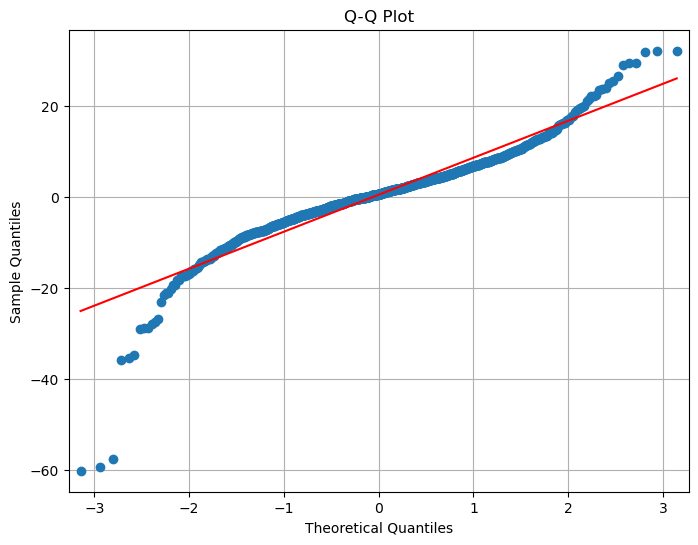

In [53]:
# Q-Q plot of the quantiles of x versus the quantiles/ppf of a distribution.
# Call qqplot() for arima_obj_fit
fig, ax = plt.subplots(figsize=(8, 6))

# Remove the first and last point from residuals
residuals = arima_obj_fit.resid[2:]

sm.qqplot(residuals, line='s', ax=ax)
plt.title('Q-Q Plot')
plt.grid(True)
plt.show()

In [54]:
print(df_clean['diffval'], df_clean['ARIMA'])

50      282.738464
51      286.528015
52      287.717468
53      283.245514
54      281.733368
           ...    
1249    927.080017
1250    890.619995
1251    903.919983
1252    916.609985
1253    898.049988
Name: diffval, Length: 1204, dtype: float64 50        0.000000
51      282.739431
52      286.720805
53      287.612418
54      283.091010
           ...    
1249    930.916623
1250    926.495543
1251    888.909092
1252    906.240979
1253    915.337968
Name: ARIMA, Length: 1204, dtype: float64


In [55]:
df_clean['diffval'].iloc[2:]

52      287.717468
53      283.245514
54      281.733368
55      283.374634
56      277.381226
           ...    
1249    927.080017
1250    890.619995
1251    903.919983
1252    916.609985
1253    898.049988
Name: diffval, Length: 1202, dtype: float64

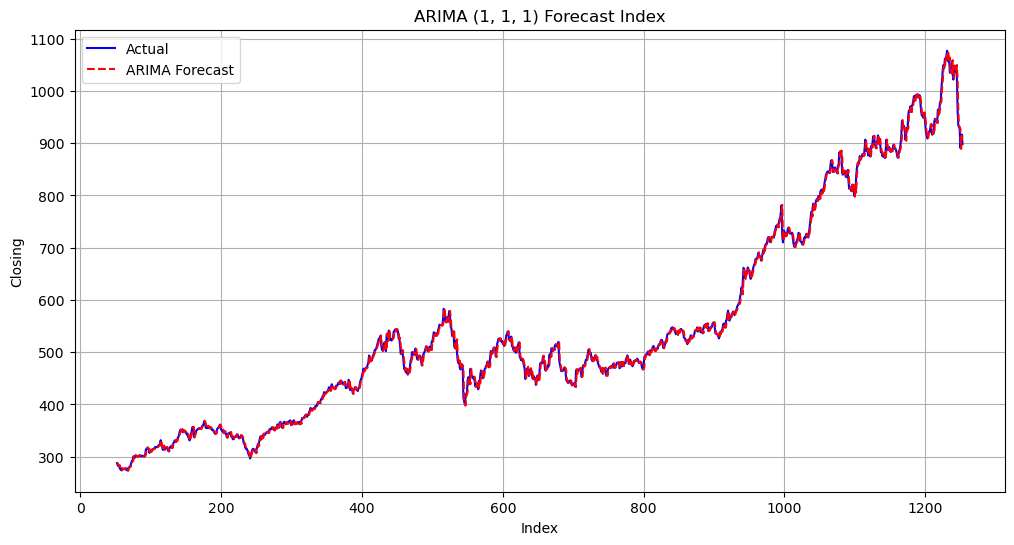

In [56]:
# Declare the objects f and array axarr
f, axarr = plt.subplots(1, sharex=True, figsize=(12, 6))

# Ignore first two rows because of difference factor d = 1
df_clean['diffval'].iloc[2:].plot(color='b', linestyle='-', ax=axarr, label='Actual')
df_clean['ARIMA'].iloc[2:].plot(color='r', linestyle='--', ax=axarr, label='ARIMA Forecast')

axarr.set_title('ARIMA (1, 1, 1) Forecast Index')
axarr.set_xlabel('Index')
axarr.set_ylabel('Closing')
axarr.legend() 
plt.grid(True)
plt.show()


In [57]:
result = arima_obj_fit.get_forecast()
forecast = result.predicted_mean

# summarize confidence intervals
intervals = [0.2, 0.1, 0.05, 0.01] #80%, 90%, 95% , 99%

for a in intervals:
    ci = result.conf_int(alpha=a)
    print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, ci[0,0], ci[0,1]))

80.0% Confidence Interval: 898.038 between 887.612 and 908.465
90.0% Confidence Interval: 898.038 between 884.656 and 911.421
95.0% Confidence Interval: 898.038 between 882.093 and 913.984
99.0% Confidence Interval: 898.038 between 877.082 and 918.995


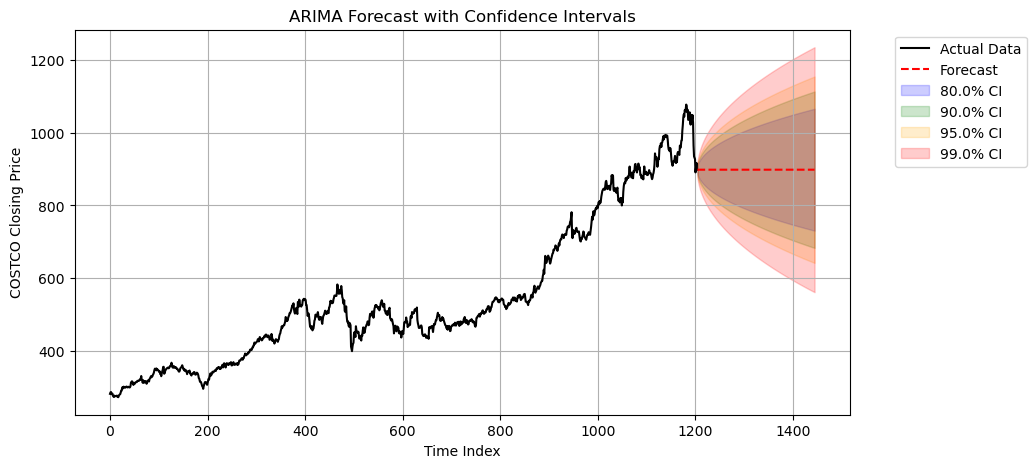

In [58]:
# Extract actual closing prices for ARIMA modeling
closing_prices = df_clean["Close"].values

# Split data into training and test sets (for validation)
train_size = int(len(closing_prices) * 0.8)  # Use 80% for training, 20% for testing
train, test = closing_prices[:train_size], closing_prices[train_size:]

# Fit an ARIMA model (1, 1, 1) model
model = sm.tsa.ARIMA(closing_prices, order=(1, 1, 1))
arima_obj_fit = model.fit()

# Forecast next points matching the length of the test set
forecast_steps = len(test)  # Forecast for the same length as test set
result = arima_obj_fit.get_forecast(steps=forecast_steps)
forecast = result.predicted_mean

# Define confidence intervals
intervals = [0.2, 0.1, 0.05, 0.01] #80%, 90%, 95% , 99%
colors = ['blue', 'green', 'orange', 'red']

# Extract past observed values and time indices
time_steps = np.arange(len(closing_prices))  # Time indices for actual values
future_steps = np.arange(len(closing_prices), len(closing_prices) + len(forecast))  # Forecast indices

# Plot actual observed values
plt.figure(figsize=(10, 5))
plt.plot(time_steps, closing_prices, label="Actual Data", color='black', linestyle='solid')

# Plot forecasted values
plt.plot(future_steps, forecast, label="Forecast", color='red', linestyle='dashed')

# Plot confidence intervals dynamically
for a, color in zip(intervals, colors):
    ci = result.conf_int(alpha=a)
    lower_bound, upper_bound = ci[:, 0], ci[:, 1]
    plt.fill_between(future_steps, lower_bound, upper_bound, color=color, alpha=0.2, label=f"{(1-a)*100:.1f}% CI")

# Labels and legend
plt.xlabel("Time Index")
plt.ylabel("COSTCO Closing Price")
plt.title("ARIMA Forecast with Confidence Intervals")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

The ARIMA forecast predicts Costco's stock price at 898.038, with confidence intervals showing the likely range of values. There's an 80% chance the price will fall between 887.612 and 908.465, increasing to a 90% probability between 884.656 and 911.421. The 95% confidence interval widens to 882.093 to 913.984, while the 99% interval suggests the broadest possible range of 877.082 to 918.995. These ranges demonstrate increasing certainty at higher confidence levels, with the model showing strongest confidence in near-term predictions while acknowledging greater potential variability in extreme cases. The central forecast of 898.038 represents the most probable outcome based on historical trends.

## SARIMA Modeling

In [59]:
# Fit the SARIMA model
best_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 21)).fit(disp=False)

# Forecast future values
steps = len(test)
forecast_result = best_model.get_forecast(steps=steps)
forecast = forecast_result.predicted_mean  # This is a Pandas Series with datetime index
# Print model summary
print("\nSARIMA Model Summary:")
print(best_model.summary())


SARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  963
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 21)   Log Likelihood               -3210.010
Date:                            Mon, 21 Apr 2025   AIC                           6430.020
Time:                                    11:44:50   BIC                           6454.255
Sample:                                         0   HQIC                          6439.258
                                            - 963                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5235      0.929      0.564      0.573      -1.297       2.344
ma.L1       

In [60]:
# Calculate evaluation metrics
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast)
mape = np.mean(np.abs((forecast - test) / np.maximum(np.abs(test), 1e-5))) * 100

print("\nModel Evaluation Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")



Model Evaluation Metrics:
MSE: 15702.7456
RMSE: 125.3106
MAE: 111.2758
MAPE: 12.07%


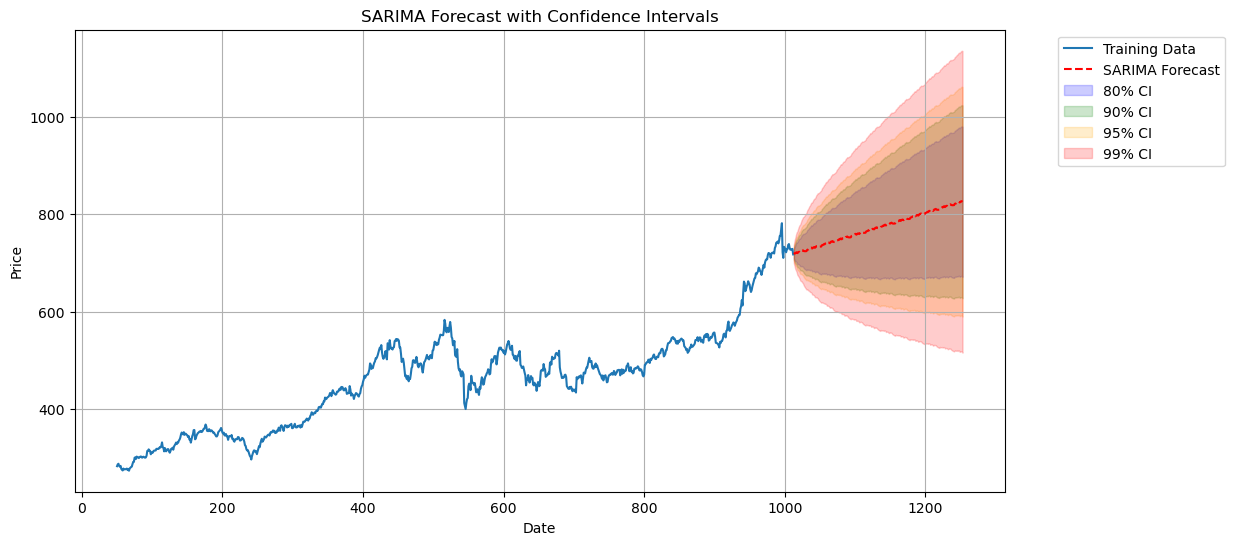

In [61]:
# df_clean is the DataFrame with 'Close' prices and datetime index
data = df_clean['Close']

# Split data into train and test sets (80-20 split)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Fit SARIMA model (using monthly seasonality = 21 trading days)
sarima_model = SARIMAX(train,
                      order=(1, 1, 1),
                      seasonal_order=(1, 1, 1, 21),
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit(disp=False)

# Generate forecasts with confidence intervals
forecast_result = sarima_model.get_forecast(steps=len(test))
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Multiple confidence intervals
intervals = [0.2, 0.1, 0.05, 0.01]  # 80%, 90%, 95%, 99%
colors = ['blue', 'green', 'orange', 'red']

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index[-1003:], train[-1003:], label='Training Data')
plt.plot(test.index, forecast, label='SARIMA Forecast', color='red',linestyle='dashed')

# Plot confidence intervals
for alpha, color in zip(intervals, colors):
    ci = sarima_model.get_forecast(steps=len(test)).conf_int(alpha=alpha)
    plt.fill_between(test.index,
                    ci.iloc[:, 0],
                    ci.iloc[:, 1],
                    color=color,
                    alpha=0.2,
                    label=f'{(1-alpha)*100:.0f}% CI')

plt.title('SARIMA Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [62]:
# Shows SARIMA confidence intervals
print("\nConfidence Intervals Summary:")
for a in intervals:
    ci = sarima_model.get_forecast(steps=len(test)).conf_int(alpha=a)
    print(f"{(1-a)*100:.1f}% CI: {forecast.iloc[0]:.3f} between {ci.iloc[0,0]:.3f} and {ci.iloc[0,1]:.3f}")



Confidence Intervals Summary:
80.0% CI: 718.022 between 708.811 and 727.232
90.0% CI: 718.022 between 706.200 and 729.843
95.0% CI: 718.022 between 703.936 and 732.107
99.0% CI: 718.022 between 699.510 and 736.533


The SARIMA model generates a forecast of 718.022 for Costco's stock price, accompanied by defined confidence intervals. The 80% confidence interval ranges from 708.811 to 727.232, the 90% interval from 706.200 to 729.843, the 95% interval from 703.936 to 732.107, and the 99% interval from 699.510 to 736.533. These intervals demonstrate progressively wider ranges as confidence levels increase, reflecting greater uncertainty in predictions. The forecast aligns with the observed upward trend in the training data. The model's confidence intervals quantify potential price variability, with tighter ranges for higher-probability outcomes and broader ranges accounting for less likely scenarios.

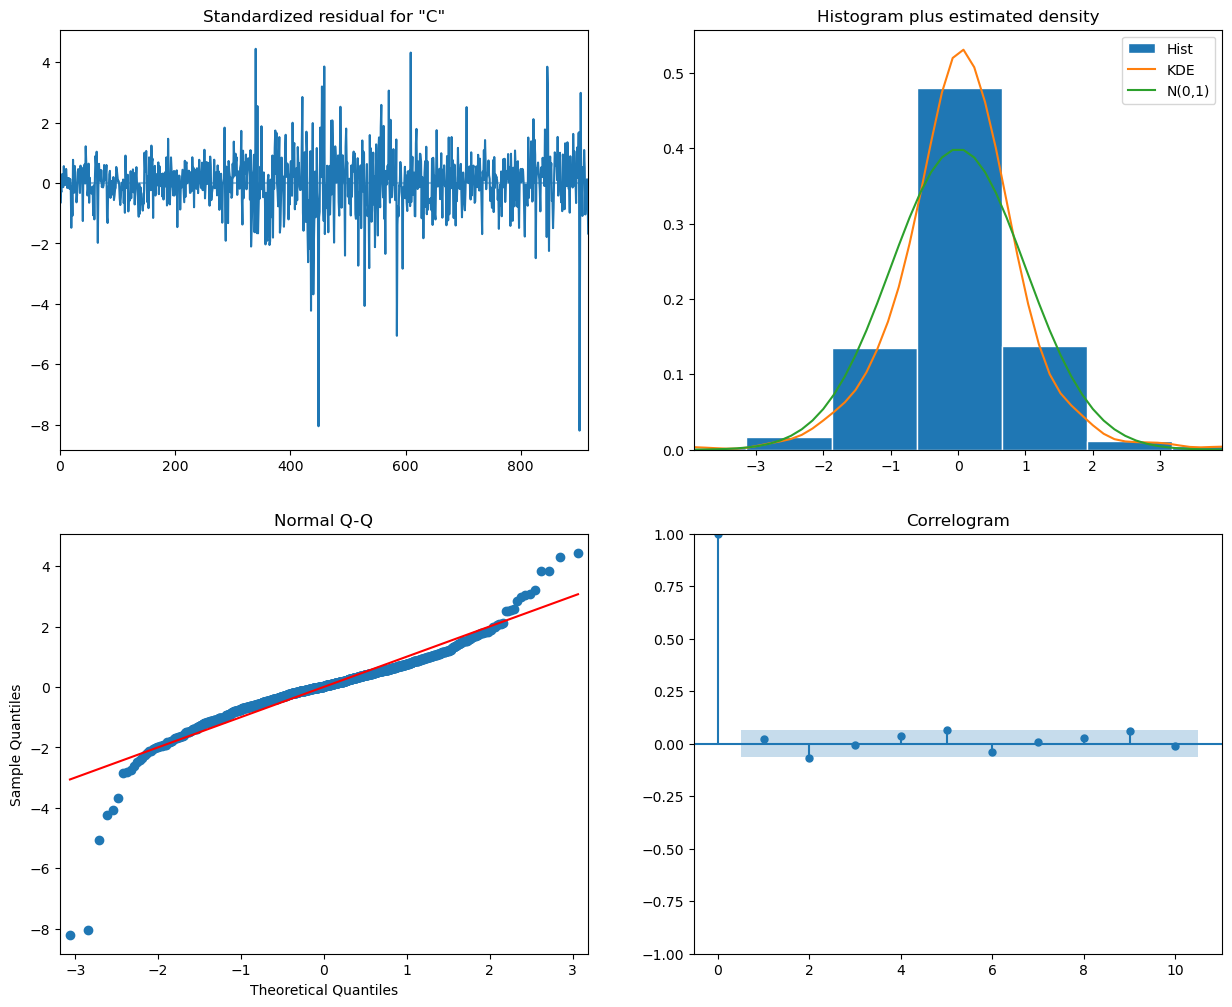

In [69]:
# Shows SARIMA diagnosing model residuals
sarima_model.plot_diagnostics(figsize = (15, 12))
plt.show()

## ARIMA vs SARIMA Comparison

In [64]:
# calculate ARIMA metrics 
arima_mse = evaluation_results['mean_squared_error'].values[0]
arima_rmse = evaluation_results['root_mean_squared_error'].values[0]
arima_mae = evaluation_results['mean_absolute_error'].values[0]
arima_mape = evaluation_results['mean_absolute_percentage_error'].values[0]

# Combine into a single DataFrame
comparison_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA'],
    'MSE': [arima_mse, mse],
    'RMSE': [arima_rmse, rmse],
    'MAE': [arima_mae, mae],
    'MAPE (%)': [arima_mape, mape]
})

# Optional: Round for presentation
comparison_df = comparison_df.round({
    'MSE': 4,
    'RMSE': 4,
    'MAE': 4,
    'MAPE (%)': 4
})

print(comparison_df)

    Model         MSE      RMSE       MAE  MAPE (%)
0   ARIMA   4577.6103   67.6580   51.7789    5.5294
1  SARIMA  15702.7456  125.3106  111.2758   12.0671


### Summary : 
ARIMA significantly outperforms SARIMA across all four key metrics including both absolute and percentage-based errors. The ARIMA model demonstrates superior performance with an MSE of 4577.6103, RMSE of 67.6580, MAE of 51.7789, and MAPE of 5.5294%. In comparison, the SARIMA model shows higher error metrics: MSE of 15702.7456, RMSE of 125.3106, MAE of 111.2758, and MAPE of 12.0671%. The ARIMA model's consistently lower error values across all metrics indicate better accuracy in forecasting compared to the SARIMA model.


# References

 - Geron, A. (2019) Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. 2nd ed. O'Reilly Media, pp. 239-279.
 - Scikit-learn developers (2025) Clustering — scikit-learn 1.6.1 documentation. Available at: https://scikit-learn.org/stable/modules/clustering.html 
 - GeeksforGeeks. (2023). How to Calculate Moving Average in a Pandas DataFrame? [Online]. Available at: https://www.geeksforgeeks.org/how-to-calculate-moving-average-in-a-pandas-dataframe/ 
 - QuantStart. (Year) K-Means Clustering of Daily OHLC Bar Data [Online]. Available at: https://www.quantstart.com/articles/k-means-clustering-of-daily-ohlc-bar-data/
 - Plotly. (Year). Candlestick Charts in Python [Online]. Available at: https://plotly.com/python/candlestick-charts/
 - Analytics Vidhya. (2020) A Detailed Introduction to K-means Clustering in Python! [Online]. Available at: https://www.analyticsvidhya.com/blog/2020/12/a-detailed-introduction-to-k-means-clustering-in-python/
 - Analytics Vidhya. (2021) K-means Clustering Simplified in Python [Online]. Available at: https://www.analyticsvidhya.com/blog/2021/04/k-means-clustering-simplified-in-python/
 - Scikit-learn. (Year) A demo of K-Means clustering on the handwritten digits data [Online]. Available at: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html 
 - Scikit-learn. (2024) sklearn.cluster.KMeans [Online]. Available at: https://scikit-learn.org/1.4/modules/generated/sklearn.cluster.KMeans.html
 - Scikit-learn. (2024) sklearn.cluster.AgglomerativeClustering [Online]. Available at: https://scikit-learn.org/1.4/modules/generated/sklearn.cluster.AgglomerativeClustering.html
 - Machine Learning Plus. (Year) Augmented Dickey Fuller Test (ADF Test): Must Read Guide [Online]. Available at: https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/
 - Analytics Vidhya. (2021) Statistical Tests to Check Stationarity in Time Series (Part 1) [Online]. Available at: https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/ 
 - AuthorLastName, Initials. (2023) Research on the Augmented Dickey-Fuller Test for Predicting Stock Prices and Returns [Online]. Available at: https://www.researchgate.net/publication/375551467_Research_on_the_Augmented_Dickey-Fuller_Test_for_Predicting_Stock_Prices_and_Returns
 - Analytics Vidhya. (2018) Auto ARIMA: Time Series Forecasting in Python and R [Online]. Available at: https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/ 
 - Prashant. (Year). Complete Guide on Time Series Analysis in Python [Jupyter Notebook]. Kaggle. Available at: https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python
 - Analytics Vidhya. (2023) SARIMA Model for Forecasting Currency Exchange Rates [Online]. Available at: https://www.analyticsvidhya.com/blog/2023/06/sarima-model-for-forecasting-currency-exchange-rates/